# MACHINE LEARNING OLS

In [4]:
#Importing libaries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from scipy import stats
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.linear_model import Ridge


In [5]:
#Importing data
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_column', None)
pd.set_option('display.max_colwidth', None)
csv_file_path = '../Modeldata/data_ready_udenkom.csv'
df_final = pd.read_csv(csv_file_path)
df_final
df_final.set_index('Unnamed: 0', inplace=True)
df_final.index.name = None
print(len(df_final))

19848


In [6]:
##Deleting observations with less than 20 m2 -> To avoid "non-appartments"
outliers_m2 = df_final[(df_final['m2'] < 20) | ((df_final['m2'] < 50) & (df_final['Boligtype_Landejendom'] == 1))]

#Square meter price:
df_final['price/m2'] = df_final['Price']/df_final['m2']

print(len(df_final))
########################################################################
# Calculate Z-scores for each value in the column
df_final['z_score_price_m2'] = stats.zscore(df_final['price/m2'])

# Define outliers as any points with a Z-score > 4 or < -4
outliers_price_m2 = df_final[(df_final['z_score_price_m2'] > 3) | (df_final['z_score_price_m2'] < -3)]
#print(outliers.sort_values(by='price/m2', ascending=False))

df_final.drop(columns='price/m2', inplace=True)
########################################################################
# Calculate Z-scores for m2
df_final['z_score_m2'] = stats.zscore(df_final['m2'])

# Define outliers as any points with a Z-score > 4 or < -4
outliers_m2_z = df_final[(df_final['z_score_m2'] > 3) | (df_final['z_score_m2'] < -3)]
#print(outliers_m2.sort_values(by='m2', ascending=True))

########################################################################

#Calculate Z-scores for price
df_final['z_score_price'] = stats.zscore(df_final['Price'])
# Define outliers as any points with a Z-score > 4 or < -4
outliers_price = df_final[(df_final['z_score_price'] > 3) | (df_final['z_score_price'] < -3)]
#print(outliers_m2.sort_values(by='m2', ascending=True))

######################################################################

# Dropping all outliers at once
outliers_combined = pd.concat([outliers_m2, outliers_price_m2, outliers_m2_z, outliers_price])
df_final = df_final.drop(outliers_combined.index)

df_final = df_final.drop('z_score_m2', axis=1)
df_final = df_final.drop('z_score_price_m2', axis=1)
df_final = df_final.drop('z_score_price', axis=1)

print(len(df_final))


19848
19216


In [7]:
y = df_final['Price']
X = df_final.drop(columns=['Price'])

In [8]:
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=1/3, random_state=42) #The random_state works as a seed

#2
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=0.5, random_state=42)

# OLS, Poly-degree=1

In [10]:
# DEFINE PIPELINE
pipe_lr = make_pipeline(PolynomialFeatures(degree=1), 
                        StandardScaler(),
                        LinearRegression())

# FIT PIPELINE TO DEVELOPMENT DATA
pipe_lr.fit(X_dev, y_dev)


Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=1)),
                ('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

LinReg_MSE 1611440904707.61
LinReg_MAE 871354.74
LinReg_MAPE 2.65
LinReg_RMSE 1269425.4230586411
LinReg_r2 0.6876159671854901


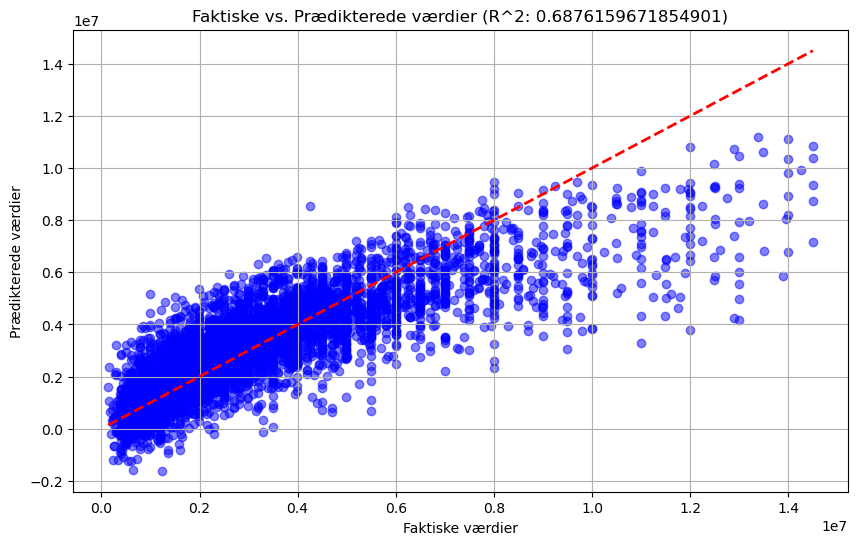

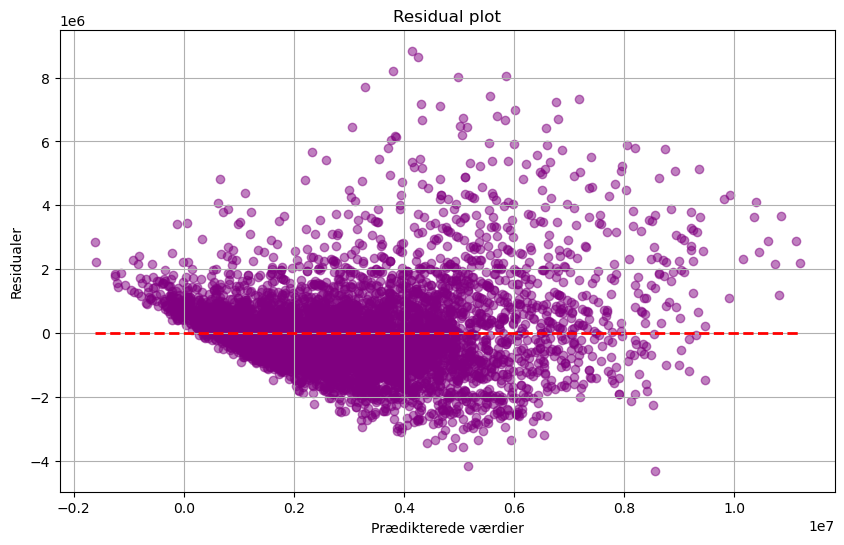

LinReg_r2 0.673928303460211


In [11]:
y_predict_lr_degree_1 = pipe_lr.predict(X_test)
print('LinReg_MSE', round(mse(y_predict_lr_degree_1,y_test), 2))
print('LinReg_MAE', round(mean_absolute_error(y_predict_lr_degree_1, y_test), 2))
print('LinReg_MAPE', round(mean_absolute_percentage_error(y_predict_lr_degree_1, y_test), 2))
print('LinReg_RMSE', np.sqrt(mse(y_predict_lr_degree_1, y_test)))
print('LinReg_r2', r2_score(y_test, y_predict_lr_degree_1))
linear_model = pipe_lr.named_steps['linearregression']
coeff = linear_model.coef_

# Plot af faktiske vs. prædikterede værdier
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_predict_lr_degree_1, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2, linestyle='--')  # Reference linje for perfekt prædiktion
plt.xlabel('Faktiske værdier')
plt.ylabel('Prædikterede værdier')
plt.title(f'Faktiske vs. Prædikterede værdier (R^2: {r2_score(y_test, y_predict_lr_degree_1)})')
plt.grid(True)
plt.show()

# Plot af residualer (fejl)
residuals = y_test - y_predict_lr_degree_1

plt.figure(figsize=(10, 6))
plt.scatter(y_predict_lr_degree_1, residuals, color='purple', alpha=0.5)
plt.hlines(0, y_predict_lr_degree_1.min(), y_predict_lr_degree_1.max(), color='red', lw=2, linestyle='--')
plt.xlabel('Prædikterede værdier')
plt.ylabel('Residualer')
plt.title('Residual plot')
plt.grid(True)
plt.show()

y_predict_lr = pipe_lr.predict(X_dev)
print('LinReg_r2', r2_score(y_dev, y_predict_lr))


# OLS, Poly-degree = 2

In [13]:
# Initializing Linear-regression-model with degree=2
from sklearn.linear_model import Lasso, LinearRegression

# DEFINE PIPELINE
pipe_lr = make_pipeline(PolynomialFeatures(degree=2), 
                        StandardScaler(),
                        LinearRegression())

# FIT PIPELINE TO DEVELOPMENT DATA
pipe_lr.fit(X_dev, y_dev)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

LinReg_MSE 3.257703830559236e+30
LinReg_MAE 75921376799579.44
LinReg_MAPE 0.33
LinReg_RMSE 1804911031203265.8
LinReg_r2 -6.315184486954676e+17


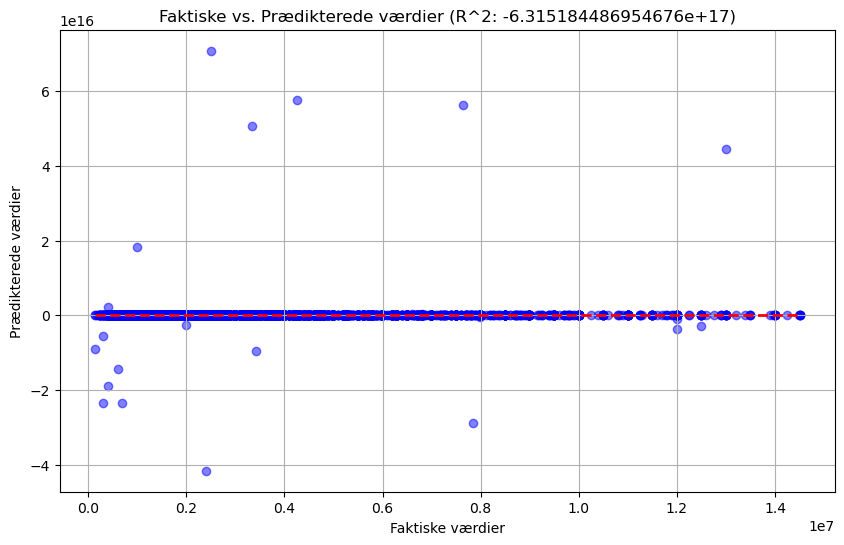

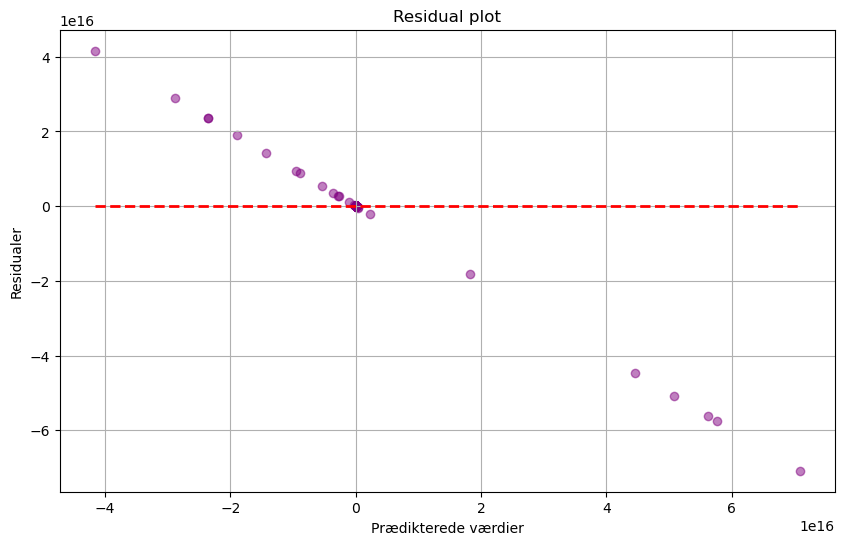

LinReg_r2 0.8812409646351578


In [14]:
y_predict_lr_degree_2 = pipe_lr.predict(X_test)
print('LinReg_MSE', round(mse(y_predict_lr_degree_2,y_test), 2))
print('LinReg_MAE', round(mean_absolute_error(y_predict_lr_degree_2, y_test), 2))
print('LinReg_MAPE', round(mean_absolute_percentage_error(y_predict_lr_degree_2, y_test), 2))
print('LinReg_RMSE', np.sqrt(mse(y_predict_lr_degree_2, y_test)))
print('LinReg_r2', r2_score(y_test, y_predict_lr_degree_2))


# Plot af faktiske vs. prædikterede værdier
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_predict_lr_degree_2, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2, linestyle='--')  # Reference linje for perfekt prædiktion
plt.xlabel('Faktiske værdier')
plt.ylabel('Prædikterede værdier')
plt.title(f'Faktiske vs. Prædikterede værdier (R^2: {r2_score(y_test, y_predict_lr_degree_2)})')
plt.grid(True)
plt.show()

# Plot af residualer (fejl)
residuals = y_test - y_predict_lr_degree_2

plt.figure(figsize=(10, 6))
plt.scatter(y_predict_lr_degree_2, residuals, color='purple', alpha=0.5)
plt.hlines(0, y_predict_lr_degree_2.min(), y_predict_lr_degree_2.max(), color='red', lw=2, linestyle='--')
plt.xlabel('Prædikterede værdier')
plt.ylabel('Residualer')
plt.title('Residual plot')
plt.grid(True)
plt.show()

y_predict_lr = pipe_lr.predict(X_dev)
print('LinReg_r2', r2_score(y_dev, y_predict_lr))

# Lasso-model, degree=1 and no Cross-validation

In [16]:
# Initialize Lasso-model with degree=1, CV=0
from sklearn.metrics import mean_squared_error as mse

# PREPARATION
perform = [] # Store performance
lambdas = np.logspace(0, 7, 66) # Grid of lambdas

# FOR EACH LAMBDA, FIT A MODEL ON TRAINING DATA, CHECK PERFORMANCE ON VALIDATION AND STORE MSE
for lambda_ in lambdas:
    pipe_lasso = make_pipeline(PolynomialFeatures(degree=1), 
                               StandardScaler(),
                               Lasso(alpha=lambda_, random_state=42))
    pipe_lasso.fit(X_train, y_train)
    y_pred = pipe_lasso.predict(X_val)
    perform.append(mse(y_val,y_pred))

# CRATE A SERIES WITH PERFORMANCE AND FIND PARM WITH LOWEST MSE    
hyperparam_perform = pd.Series(perform,index=lambdas)
optimal = hyperparam_perform.nsmallest(1)    
print('Optimal lambda:', optimal.index[0])
print('Validation MSE: %.3f' % optimal.values[0])

Optimal lambda: 2180.025323490052
Validation MSE: 1733380991358.632


In [17]:
# INSERT OPTIMAL LAMBDA INTO NEW MODEL
pipe_lasso = make_pipeline(PolynomialFeatures(degree=1), 
                           StandardScaler(),
                           Lasso(alpha=optimal.index[0]))

# FIT NEW MODEL ON ALL OF THE DEVELOPMENT (non-test) DATA TO BUILD BEST POSSIBLE MODEL
pipe_lasso.fit(X_dev, y_dev) 

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=1)),
                ('standardscaler', StandardScaler()),
                ('lasso', Lasso(alpha=2180.025323490052))])

Lasso_MSE_de1 1609887181281.63
Lasso_MAE_de1 869326.22
Lasso_MAPE_de1 0.73
Lasso_RMSE_de1 1268813.2964631293
Lasso_R2_de1 0.6879171624625042


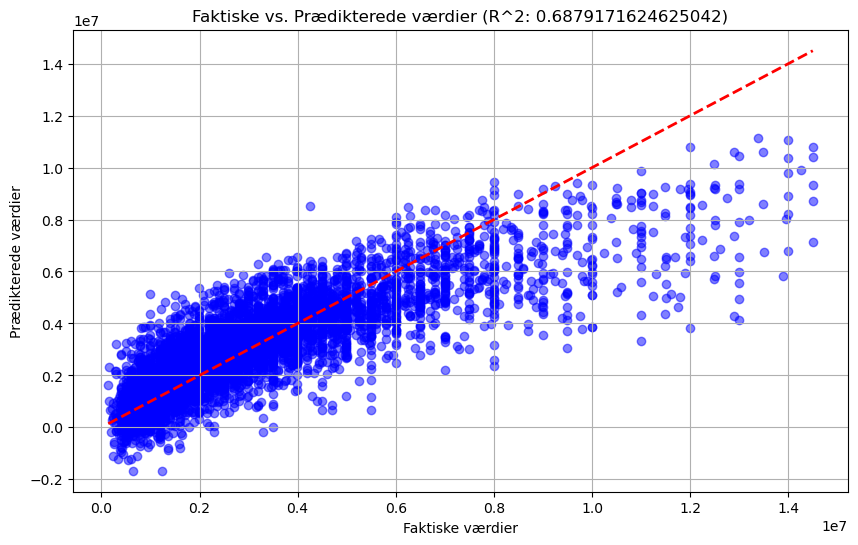

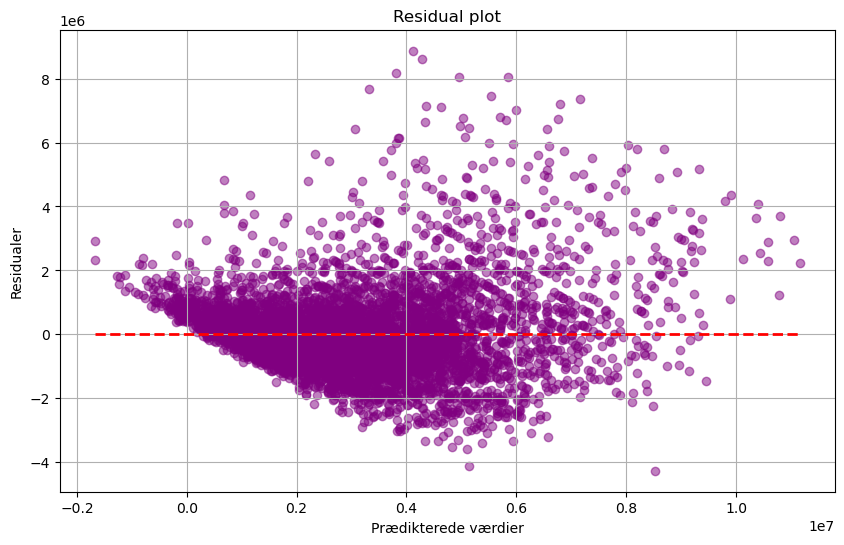

In [18]:
#Printing MSE, MAE, MAPE, RMSE
y_test_pred_lasso_degree_1 = pipe_lasso.predict(X_test)
print('Lasso_MSE_de1', round(mse(y_test_pred_lasso_degree_1,y_test), 2))
print('Lasso_MAE_de1', round(mean_absolute_error(y_test_pred_lasso_degree_1, y_test), 2))
print('Lasso_MAPE_de1', round(mean_absolute_percentage_error(y_test_pred_lasso_degree_1, y_test), 2))
print('Lasso_RMSE_de1', np.sqrt(mse(y_test_pred_lasso_degree_1, y_test)))
print('Lasso_R2_de1', r2_score(y_test, y_test_pred_lasso_degree_1))

# Plot af faktiske vs. prædikterede værdier
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred_lasso_degree_1, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2, linestyle='--')  # Reference linje for perfekt prædiktion
plt.xlabel('Faktiske værdier')
plt.ylabel('Prædikterede værdier')
plt.title(f'Faktiske vs. Prædikterede værdier (R^2: {r2_score(y_test, y_test_pred_lasso_degree_1)})')
plt.grid(True)
plt.show()

# Plot af residualer (fejl)
residuals = y_test - y_test_pred_lasso_degree_1

plt.figure(figsize=(10, 6))
plt.scatter(y_test_pred_lasso_degree_1, residuals, color='purple', alpha=0.5)
plt.hlines(0, y_test_pred_lasso_degree_1.min(), y_test_pred_lasso_degree_1.max(), color='red', lw=2, linestyle='--')
plt.xlabel('Prædikterede værdier')
plt.ylabel('Residualer')
plt.title('Residual plot')
plt.grid(True)
plt.show()


# LASSO-MODEL MED DEGREE=2 and no Cross-validation

In [76]:
# Initialize Lasso-model with degree=2, CV=0
from sklearn.metrics import mean_squared_error as mse

# PREPARATION
perform = [] # Store performance
lambdas = np.logspace(0, 7, 66) # Grid of lambdas

# FOR EACH LAMBDA, FIT A MODEL ON TRAINING DATA, CHECK PERFORMANCE ON VALIDATION AND STORE MSE
for lambda_ in lambdas:
    pipe_lasso = make_pipeline(PolynomialFeatures(degree=2), 
                               StandardScaler(),
                               Lasso(alpha=lambda_, random_state=42))
    pipe_lasso.fit(X_train, y_train)
    y_pred = pipe_lasso.predict(X_val)
    perform.append(mse(y_val,y_pred))

# CRATE A SERIES WITH PERFORMANCE AND FIND PARM WITH LOWEST MSE    
hyperparam_perform = pd.Series(perform,index=lambdas)
optimal = hyperparam_perform.nsmallest(1)    
print('Optimal lambda:', optimal.index[0])
print('Validation MSE: %.3f' % optimal.values[0])

Optimal lambda: 42733.57542109324
Validation MSE: 1481125300112.568


In [80]:
# INSERT OPTIMAL LAMBDA INTO NEW MODEL
pipe_lasso = make_pipeline(PolynomialFeatures(degree=2), 
                           StandardScaler(),
                           Lasso(alpha=optimal.index[0]))

# FIT NEW MODEL ON ALL OF THE DEVELOPMENT (non-test) DATA TO BUILD BEST POSSIBLE MODEL
pipe_lasso.fit(X_dev, y_dev) 

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('standardscaler', StandardScaler()),
                ('lasso', Lasso(alpha=42733.57542109324))])

Lasso_MSE_de2 999661342526.52
Lasso_MAE_de2 673547.36
Lasso_MAPE_de2 0.27
Lasso_RMSE_de2 999830.6569247196
Lasso_R2_de2 0.8062117942302935


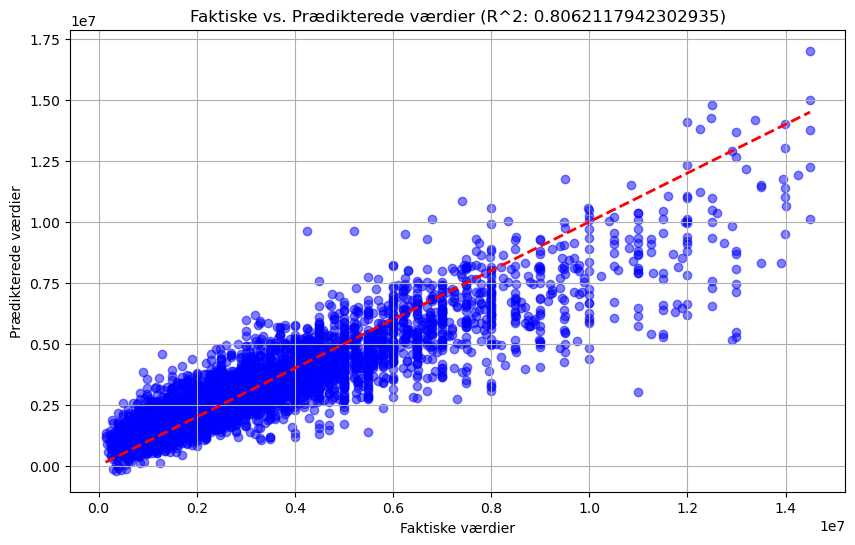

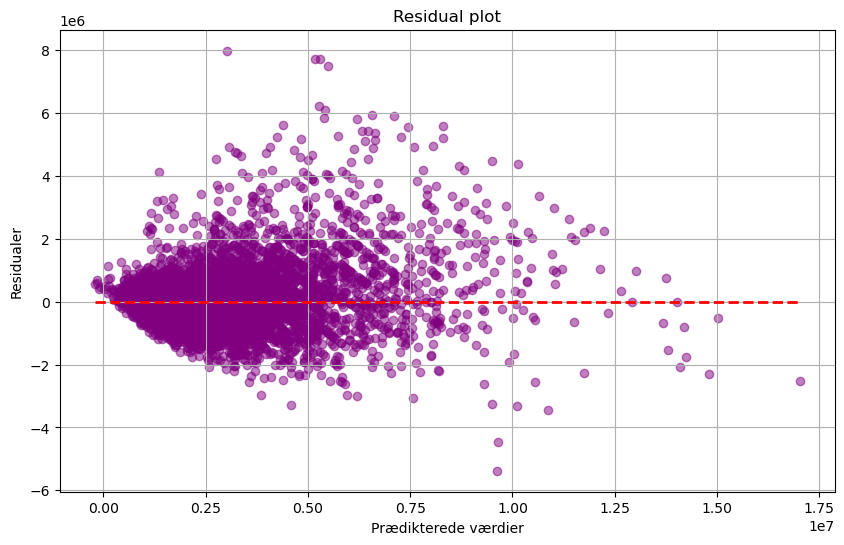

In [81]:
#Printing MSE, MAE, MAPE, RMSE
y_test_pred_lasso_degree_2 = pipe_lasso.predict(X_test)
print('Lasso_MSE_de2', round(mse(y_test_pred_lasso_degree_2,y_test), 2))
print('Lasso_MAE_de2', round(mean_absolute_error(y_test_pred_lasso_degree_2, y_test), 2))
print('Lasso_MAPE_de2', round(mean_absolute_percentage_error(y_test_pred_lasso_degree_2, y_test), 2))
print('Lasso_RMSE_de2', np.sqrt(mse(y_test_pred_lasso_degree_2, y_test)))
print('Lasso_R2_de2', r2_score(y_test, y_test_pred_lasso_degree_2))

# Plot af faktiske vs. prædikterede værdier
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred_lasso_degree_2, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2, linestyle='--')  # Reference linje for perfekt prædiktion
plt.xlabel('Faktiske værdier')
plt.ylabel('Prædikterede værdier')
plt.title(f'Faktiske vs. Prædikterede værdier (R^2: {r2_score(y_test, y_test_pred_lasso_degree_2)})')
plt.grid(True)
plt.show()

# Plot af residualer (fejl)
residuals = y_test - y_test_pred_lasso_degree_2

plt.figure(figsize=(10, 6))
plt.scatter(y_test_pred_lasso_degree_2, residuals, color='purple', alpha=0.5)
plt.hlines(0, y_test_pred_lasso_degree_2.min(), y_test_pred_lasso_degree_2.max(), color='red', lw=2, linestyle='--')
plt.xlabel('Prædikterede værdier')
plt.ylabel('Residualer')
plt.title('Residual plot')
plt.grid(True)
plt.show()


In [23]:
"""
from sklearn.model_selection import validation_curve
lambdas = np.logspace(0, 7, 66) # Grid of lambdas
# FIT AND EVALUATE FOR DIFFERENT LAMBDAS
train_scores, test_scores = \
    validation_curve(estimator=pipe_lasso,
                     X=X_dev,
                     y=y_dev,
                     param_name='lasso__alpha', #built-in name of hyperparameter
                     param_range=lambdas, #values to consider
                     scoring='neg_mean_squared_error', 
                     )

# OBTAIN MSE FOR DIFFERENT LAMBDAS AND PRINT BEST
mse_score = pd.DataFrame({'Train':-train_scores.mean(axis=1),
                          'Validation':-test_scores.mean(axis=1),
                          'lambda':lambdas})\
              .set_index('lambda')   
print(mse_score.Validation.nsmallest(1))
"""

"\nfrom sklearn.model_selection import validation_curve\nlambdas = np.logspace(0, 7, 66) # Grid of lambdas\n# FIT AND EVALUATE FOR DIFFERENT LAMBDAS\ntrain_scores, test_scores =     validation_curve(estimator=pipe_lasso,\n                     X=X_dev,\n                     y=y_dev,\n                     param_name='lasso__alpha', #built-in name of hyperparameter\n                     param_range=lambdas, #values to consider\n                     scoring='neg_mean_squared_error', \n                     )\n\n# OBTAIN MSE FOR DIFFERENT LAMBDAS AND PRINT BEST\nmse_score = pd.DataFrame({'Train':-train_scores.mean(axis=1),\n                          'Validation':-test_scores.mean(axis=1),\n                          'lambda':lambdas})              .set_index('lambda')   \nprint(mse_score.Validation.nsmallest(1))\n"

In [24]:
#np.sqrt(mse_score).plot(logx=True, figsize=(10,6));

# Lasso, Poly-degree = 1, CV = 5

Optimal lambda: 0.01
Validation MSE: 1993864467426.955


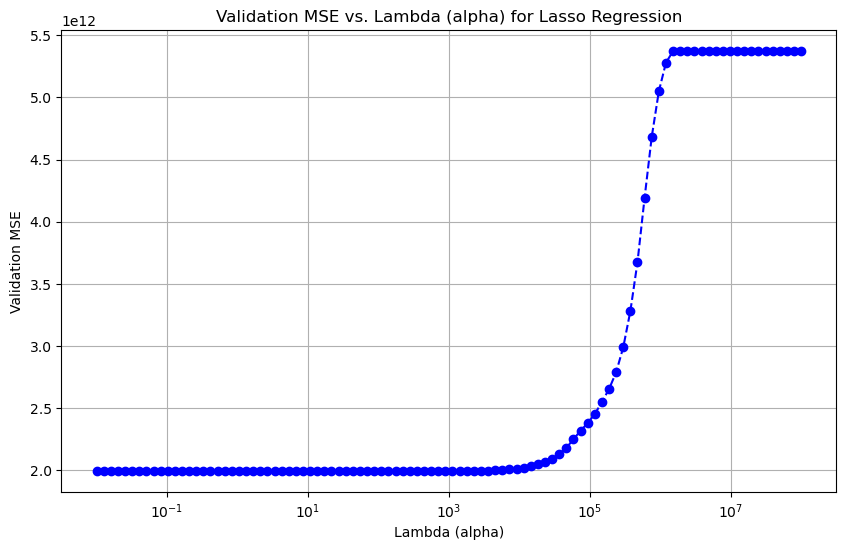

In [26]:
# PREPARATION
lambdas = np.logspace(-2, 8, 100)  # Grid of lambdas
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation

# Store performance for each alpha
perform = []

# FOR EACH LAMBDA, PERFORM 5-FOLD CROSS VALIDATION
for lambda_ in lambdas:
    fold_mse = []
    
    for train_index, val_index in kf.split(X_dev):
        X_train_fold, X_val_fold = X_dev.iloc[train_index], X_dev.iloc[val_index]
        y_train_fold, y_val_fold = y_dev.iloc[train_index], y_dev.iloc[val_index]

        # Initialize and fit the Ridge model within the pipeline
        pipe_lasso = make_pipeline(PolynomialFeatures(degree=1), 
                                   StandardScaler(),
                                   Lasso(alpha=lambda_, random_state=42))
        pipe_lasso.fit(X_train_fold, y_train_fold)
        
        # Predict on the validation fold
        y_pred_fold = pipe_lasso.predict(X_val_fold)
        
        # Calculate MSE for this fold and store it
        fold_mse.append(mse(y_val_fold, y_pred_fold))
    
    # Average MSE across all folds for the current lambda
    perform.append(np.mean(fold_mse))

# CREATE A SERIES WITH PERFORMANCE AND FIND LAMBDA WITH LOWEST MSE    
hyperparam_perform = pd.Series(perform, index=lambdas)
optimal = hyperparam_perform.nsmallest(1)    
print('Optimal lambda:', optimal.index[0])
print('Validation MSE: %.3f' % optimal.values[0])

# Visualize the validation curve
plt.figure(figsize=(10, 6))
plt.plot(lambdas, perform, marker='o', linestyle='--', color='blue')
plt.xscale('log')
plt.xlabel('Lambda (alpha)')
plt.ylabel('Validation MSE')
plt.title('Validation MSE vs. Lambda (alpha) for Lasso Regression')
plt.grid(True)
plt.show()

In [27]:
# INSERT OPTIMAL LAMBDA INTO NEW MODEL
pipe_lasso = make_pipeline(PolynomialFeatures(degree=1), 
                           StandardScaler(),
                           Lasso(alpha=optimal.index[0]))

# FIT NEW MODEL ON ALL OF THE DEVELOPMENT (non-test) DATA TO BUILD BEST POSSIBLE MODEL
pipe_lasso.fit(X_dev, y_dev) 

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=1)),
                ('standardscaler', StandardScaler()),
                ('lasso', Lasso(alpha=0.01))])

Lasso_MSE_de1_cv_5 1611440891992.88
Lasso_MAE_de1_cv_5 871354.73
Lasso_MAPE_de1_cv_5 2.65
Lasso_RMSE_de1_cv_5 1269425.4180505748
Lasso_R2_de1_cv_5 0.6876159696502904


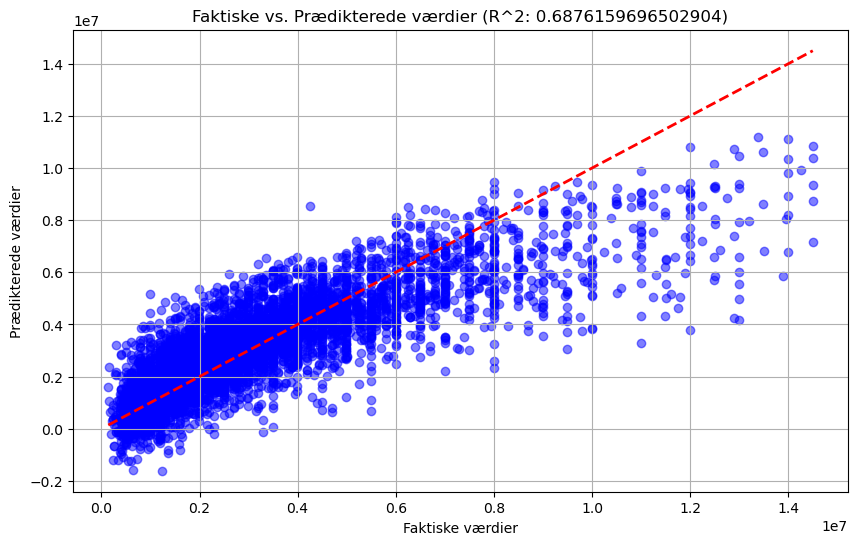

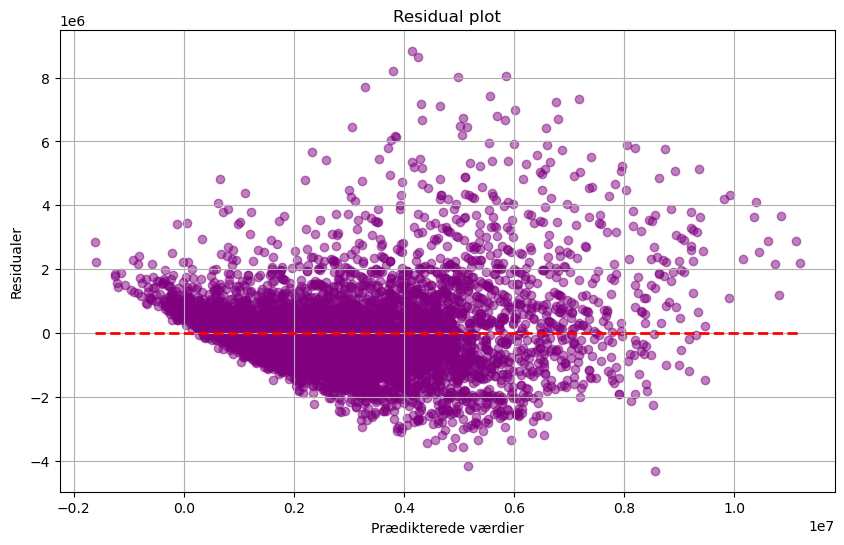

In [28]:
# Printing MSE, MAE, MAPE, RMSE
y_test_pred_lasso_degree_1_cv_5 = pipe_lasso.predict(X_test)
print('Lasso_MSE_de1_cv_5', round(mse(y_test_pred_lasso_degree_1_cv_5, y_test), 2))
print('Lasso_MAE_de1_cv_5', round(mean_absolute_error(y_test_pred_lasso_degree_1_cv_5, y_test), 2))
print('Lasso_MAPE_de1_cv_5', round(mean_absolute_percentage_error(y_test_pred_lasso_degree_1_cv_5, y_test), 2))
print('Lasso_RMSE_de1_cv_5', np.sqrt(mse(y_test_pred_lasso_degree_1_cv_5, y_test)))
print('Lasso_R2_de1_cv_5', r2_score(y_test, y_test_pred_lasso_degree_1_cv_5))


# Plot af faktiske vs. prædikterede værdier
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred_lasso_degree_1_cv_5, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2, linestyle='--')  # Reference linje for perfekt prædiktion
plt.xlabel('Faktiske værdier')
plt.ylabel('Prædikterede værdier')
plt.title(f'Faktiske vs. Prædikterede værdier (R^2: {r2_score(y_test, y_test_pred_lasso_degree_1_cv_5)})')
plt.grid(True)
plt.show()

# Plot af residualer (fejl)
residuals = y_test - y_test_pred_lasso_degree_1_cv_5

plt.figure(figsize=(10, 6))
plt.scatter(y_test_pred_lasso_degree_1_cv_5, residuals, color='purple', alpha=0.5)
plt.hlines(0, y_test_pred_lasso_degree_1_cv_5.min(), y_test_pred_lasso_degree_1_cv_5.max(), color='red', lw=2, linestyle='--')
plt.xlabel('Prædikterede værdier')
plt.ylabel('Residualer')
plt.title('Residual plot')
plt.grid(True)
plt.show()


# LASSO, poly-degree=2, CV=5

In [30]:
"""
# PREPARATION
lambdas = np.logspace(-2, 8, 100)  # Grid of lambdas
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation

# Store performance for each alpha
perform = []

# FOR EACH LAMBDA, PERFORM 5-FOLD CROSS VALIDATION
for lambda_ in lambdas:
    fold_mse = []
    
    for train_index, val_index in kf.split(X_dev):
        X_train_fold, X_val_fold = X_dev.iloc[train_index], X_dev.iloc[val_index]
        y_train_fold, y_val_fold = y_dev.iloc[train_index], y_dev.iloc[val_index]

        # Initialize and fit the Ridge model within the pipeline
        pipe_lasso = make_pipeline(PolynomialFeatures(degree=2), 
                                   StandardScaler(),
                                   Lasso(alpha=lambda_, random_state=42))
        pipe_lasso.fit(X_train_fold, y_train_fold)
        
        # Predict on the validation fold
        y_pred_fold = pipe_lasso.predict(X_val_fold)
        
        # Calculate MSE for this fold and store it
        fold_mse.append(mse(y_val_fold, y_pred_fold))
    
    # Average MSE across all folds for the current lambda
    perform.append(np.mean(fold_mse))

# CREATE A SERIES WITH PERFORMANCE AND FIND LAMBDA WITH LOWEST MSE    
hyperparam_perform = pd.Series(perform, index=lambdas)
optimal = hyperparam_perform.nsmallest(1)    
print('Optimal lambda:', optimal.index[0])
print('Validation MSE: %.3f' % optimal.values[0])

# Visualize the validation curve
plt.figure(figsize=(10, 6))
plt.plot(lambdas, perform, marker='o', linestyle='--', color='blue')
plt.xscale('log')
plt.xlabel('Lambda (alpha)')
plt.ylabel('Validation MSE')
plt.title('Validation MSE vs. Lambda (alpha) for Lasso Regression')
plt.grid(True)
plt.show()
"""

"\n# PREPARATION\nlambdas = np.logspace(-2, 8, 100)  # Grid of lambdas\nkf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation\n\n# Store performance for each alpha\nperform = []\n\n# FOR EACH LAMBDA, PERFORM 5-FOLD CROSS VALIDATION\nfor lambda_ in lambdas:\n    fold_mse = []\n    \n    for train_index, val_index in kf.split(X_dev):\n        X_train_fold, X_val_fold = X_dev.iloc[train_index], X_dev.iloc[val_index]\n        y_train_fold, y_val_fold = y_dev.iloc[train_index], y_dev.iloc[val_index]\n\n        # Initialize and fit the Ridge model within the pipeline\n        pipe_lasso = make_pipeline(PolynomialFeatures(degree=2), \n                                   StandardScaler(),\n                                   Lasso(alpha=lambda_, random_state=42))\n        pipe_lasso.fit(X_train_fold, y_train_fold)\n        \n        # Predict on the validation fold\n        y_pred_fold = pipe_lasso.predict(X_val_fold)\n        \n        # Calculate MSE for this fold an

In [31]:
"""
# INSERT OPTIMAL LAMBDA INTO NEW MODEL
pipe_lasso = make_pipeline(PolynomialFeatures(degree=2), 
                           StandardScaler(),
                           Lasso(alpha=optimal.index[0]))

# FIT NEW MODEL ON ALL OF THE DEVELOPMENT (non-test) DATA TO BUILD BEST POSSIBLE MODEL
pipe_lasso.fit(X_dev, y_dev) 
"""

'\n# INSERT OPTIMAL LAMBDA INTO NEW MODEL\npipe_lasso = make_pipeline(PolynomialFeatures(degree=2), \n                           StandardScaler(),\n                           Lasso(alpha=optimal.index[0]))\n\n# FIT NEW MODEL ON ALL OF THE DEVELOPMENT (non-test) DATA TO BUILD BEST POSSIBLE MODEL\npipe_lasso.fit(X_dev, y_dev) \n'

In [32]:
"""
# Printing MSE, MAE, MAPE, RMSE
y_test_pred_lasso_degree_2_cv_5 = pipe_lasso.predict(X_test)
print('Lasso_MSE_de2_cv_5', round(mse(y_test_pred_lasso_degree_2_cv_5, y_test), 2))
print('Lasso_MAE_de2_cv_5', round(mean_absolute_error(y_test_pred_lasso_degree_2_cv_5, y_test), 2))
print('Lasso_MAPE_de2_cv_5', round(mean_absolute_percentage_error(y_test_pred_lasso_degree_2_cv_5, y_test), 2))
print('Lasso_RMSE_de2_cv_5', np.sqrt(mse(y_test_pred_lasso_degree_2_cv_5, y_test)))
print('Lasso_R2_de2_cv_5', r2_score(y_test, y_test_pred_lasso_degree_2_cv_5))


# Plot af faktiske vs. prædikterede værdier
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred_lasso_degree_2_cv_5, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2, linestyle='--')  # Reference linje for perfekt prædiktion
plt.xlabel('Faktiske værdier')
plt.ylabel('Prædikterede værdier')
plt.title(f'Faktiske vs. Prædikterede værdier (R^2: {r2_score(y_test, y_test_pred_lasso_degree_2_cv_5)})')
plt.grid(True)
plt.show()

# Plot af residualer (fejl)
residuals = y_test - y_test_pred_lasso_degree_2_cv_5

plt.figure(figsize=(10, 6))
plt.scatter(y_test_pred_lasso_degree_2_cv_5, residuals, color='purple', alpha=0.5)
plt.hlines(0, y_test_pred_lasso_degree_2_cv_5.min(), y_test_pred_lasso_degree_2_cv_5.max(), color='red', lw=2, linestyle='--')
plt.xlabel('Prædikterede værdier')
plt.ylabel('Residualer')
plt.title('Residual plot')
plt.grid(True)
plt.show()
"""

"\n# Printing MSE, MAE, MAPE, RMSE\ny_test_pred_lasso_degree_2_cv_5 = pipe_lasso.predict(X_test)\nprint('Lasso_MSE_de2_cv_5', round(mse(y_test_pred_lasso_degree_2_cv_5, y_test), 2))\nprint('Lasso_MAE_de2_cv_5', round(mean_absolute_error(y_test_pred_lasso_degree_2_cv_5, y_test), 2))\nprint('Lasso_MAPE_de2_cv_5', round(mean_absolute_percentage_error(y_test_pred_lasso_degree_2_cv_5, y_test), 2))\nprint('Lasso_RMSE_de2_cv_5', np.sqrt(mse(y_test_pred_lasso_degree_2_cv_5, y_test)))\nprint('Lasso_R2_de2_cv_5', r2_score(y_test, y_test_pred_lasso_degree_2_cv_5))\n\n\n# Plot af faktiske vs. prædikterede værdier\nplt.figure(figsize=(10, 6))\nplt.scatter(y_test, y_test_pred_lasso_degree_2_cv_5, color='blue', alpha=0.5)\nplt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2, linestyle='--')  # Reference linje for perfekt prædiktion\nplt.xlabel('Faktiske værdier')\nplt.ylabel('Prædikterede værdier')\nplt.title(f'Faktiske vs. Prædikterede værdier (R^2: {r2_score(y_tes

# RIDGE MODEL, degree = 1, CV=0

Optimal lambda: 27.8255940220712
Validation MSE: 1732777389380.816


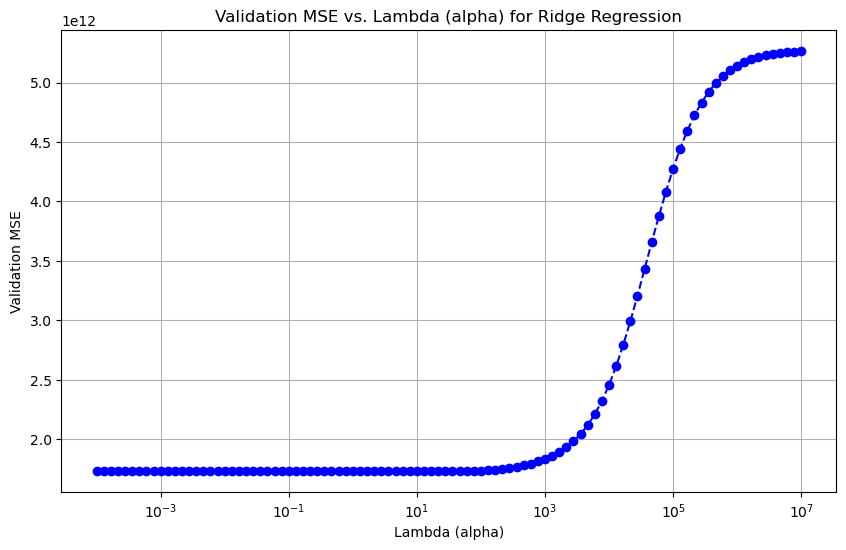

In [34]:
#Initialize the Ridge-model with degree = 1 and cv = 0
# Initialize Lasso-model with degree=2, CV=0

# PREPARATION
perform = [] # Store performance
lambdas = np.logspace(-4, 7, 100) # Grid of lambdas

# FOR EACH LAMBDA, FIT A MODEL ON TRAINING DATA, CHECK PERFORMANCE ON VALIDATION AND STORE MSE
for lambda_ in lambdas:
    pipe_ridge = make_pipeline(PolynomialFeatures(degree=1), 
                               StandardScaler(),
                               Ridge(alpha=lambda_, random_state=42))
    pipe_ridge.fit(X_train, y_train)
    y_pred = pipe_ridge.predict(X_val)
    perform.append(mse(y_val,y_pred))

# CRATE A SERIES WITH PERFORMANCE AND FIND PARM WITH LOWEST MSE    
hyperparam_perform = pd.Series(perform,index=lambdas)
optimal = hyperparam_perform.nsmallest(1)    
print('Optimal lambda:', optimal.index[0])
print('Validation MSE: %.3f' % optimal.values[0])

# Visualize the validation curve
plt.figure(figsize=(10, 6))
plt.plot(lambdas, perform, marker='o', linestyle='--', color='blue')
plt.xscale('log')
plt.xlabel('Lambda (alpha)')
plt.ylabel('Validation MSE')
plt.title('Validation MSE vs. Lambda (alpha) for Ridge Regression')
plt.grid(True)
plt.show()



In [35]:
# INSERT OPTIMAL LAMBDA INTO NEW MODEL
pipe_ridge = make_pipeline(PolynomialFeatures(degree=1), 
                           StandardScaler(),
                           Ridge(alpha=optimal.index[0]))

# FIT NEW MODEL ON ALL OF THE DEVELOPMENT (non-test) DATA TO BUILD BEST POSSIBLE MODEL
pipe_ridge.fit(X_dev, y_dev) 

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=1)),
                ('standardscaler', StandardScaler()),
                ('ridge', Ridge(alpha=27.8255940220712))])

Ridge_MSE_de1 1610838672846.31
Ridge_MAE_de1 870426.78
Ridge_MAPE_de1 1.04
Ridge_RMSE_de1 1269188.194416537
Ridge_R2_de1 0.687732712153905


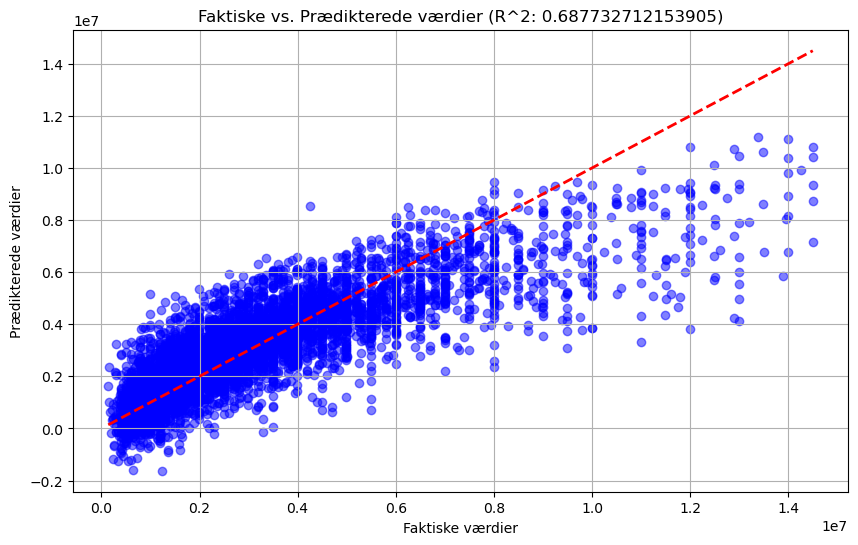

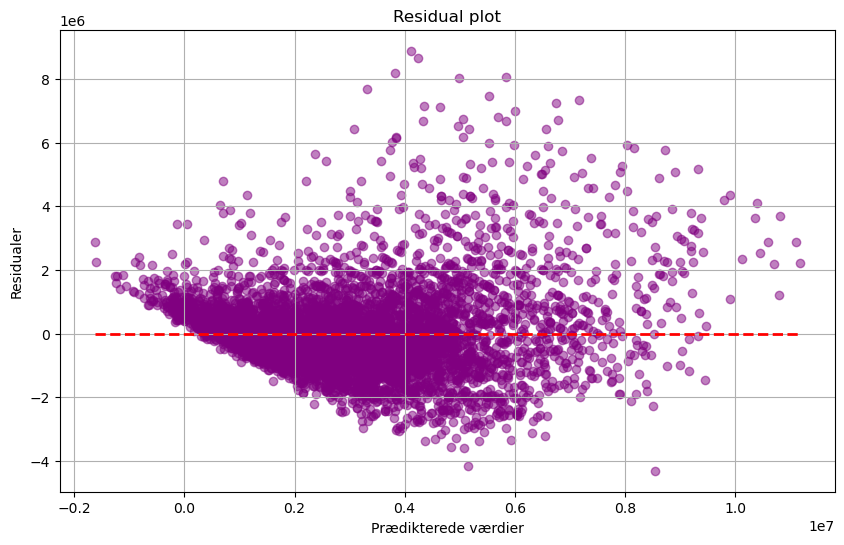

[5130342.19039104 4142722.88669359 4171585.92395256 ... 3597250.56806446
 3983150.6751052  3677616.30494237]


In [36]:
#Printing MSE, MAE, MAPE, RMSE
y_test_pred_ridge_degree_1 = pipe_ridge.predict(X_test)
print('Ridge_MSE_de1', round(mse(y_test_pred_ridge_degree_1,y_test), 2))
print('Ridge_MAE_de1', round(mean_absolute_error(y_test_pred_ridge_degree_1, y_test), 2))
print('Ridge_MAPE_de1', round(mean_absolute_percentage_error(y_test_pred_ridge_degree_1, y_test), 2))
print('Ridge_RMSE_de1', np.sqrt(mse(y_test_pred_ridge_degree_1, y_test)))
print('Ridge_R2_de1', r2_score(y_test, y_test_pred_ridge_degree_1))

# Plot af faktiske vs. prædikterede værdier
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred_ridge_degree_1, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2, linestyle='--')  # Reference linje for perfekt prædiktion
plt.xlabel('Faktiske værdier')
plt.ylabel('Prædikterede værdier')
plt.title(f'Faktiske vs. Prædikterede værdier (R^2: {r2_score(y_test, y_test_pred_ridge_degree_1)})')
plt.grid(True)
plt.show()

# Plot af residualer (fejl)
residuals = y_test - y_test_pred_ridge_degree_1

plt.figure(figsize=(10, 6))
plt.scatter(y_test_pred_ridge_degree_1, residuals, color='purple', alpha=0.5)
plt.hlines(0, y_test_pred_ridge_degree_1.min(), y_test_pred_ridge_degree_1.max(), color='red', lw=2, linestyle='--')
plt.xlabel('Prædikterede værdier')
plt.ylabel('Residualer')
plt.title('Residual plot')
plt.grid(True)
plt.show()

print(y_test_pred_ridge_degree_1)

# RIDGE, degree=2, CV=0

Optimal lambda: 7220.8090183854565
Validation MSE: 1488794990618.296


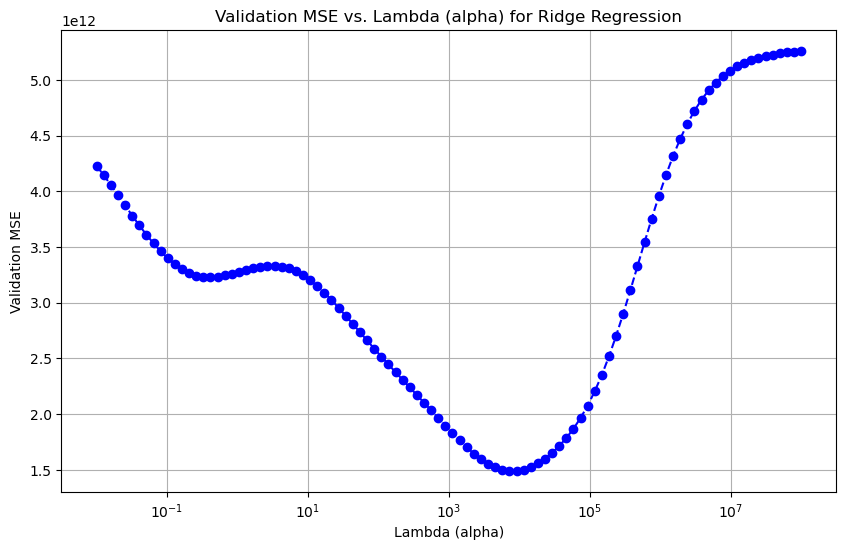

In [39]:
#Initialize the Ridge-model with degree = 1 and cv = 0
# Initialize Lasso-model with degree=2, CV=0

# PREPARATION
perform = [] # Store performance
lambdas = np.logspace(-2, 8, 100) # Grid of lambdas

# FOR EACH LAMBDA, FIT A MODEL ON TRAINING DATA, CHECK PERFORMANCE ON VALIDATION AND STORE MSE
for lambda_ in lambdas:
    pipe_ridge = make_pipeline(PolynomialFeatures(degree=2), 
                               StandardScaler(),
                               Ridge(alpha=lambda_, random_state=42))
    pipe_ridge.fit(X_train, y_train)
    y_pred = pipe_ridge.predict(X_val)
    perform.append(mse(y_val,y_pred))

# CRATE A SERIES WITH PERFORMANCE AND FIND PARM WITH LOWEST MSE    
hyperparam_perform = pd.Series(perform,index=lambdas)
optimal = hyperparam_perform.nsmallest(1)    
print('Optimal lambda:', optimal.index[0])
print('Validation MSE: %.3f' % optimal.values[0])

# Visualize the validation curve
plt.figure(figsize=(10, 6))
plt.plot(lambdas, perform, marker='o', linestyle='--', color='blue')
plt.xscale('log')
plt.xlabel('Lambda (alpha)')
plt.ylabel('Validation MSE')
plt.title('Validation MSE vs. Lambda (alpha) for Ridge Regression')
plt.grid(True)
plt.show()





In [40]:
# INSERT OPTIMAL LAMBDA INTO NEW MODEL
pipe_ridge = make_pipeline(PolynomialFeatures(degree=2), 
                           StandardScaler(),
                           Ridge(alpha=optimal.index[0]))

# FIT NEW MODEL ON ALL OF THE DEVELOPMENT (non-test) DATA TO BUILD BEST POSSIBLE MODEL
pipe_ridge.fit(X_dev, y_dev) 

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('standardscaler', StandardScaler()),
                ('ridge', Ridge(alpha=7220.8090183854565))])

Ridge_MSE_de2 1051383000550.63
Ridge_MAE_de2 681528.0
Ridge_MAPE_de2 0.31
Ridge_RMSE_de2 1025369.6896976368
Ridge_R2_de2 0.7961853513925672


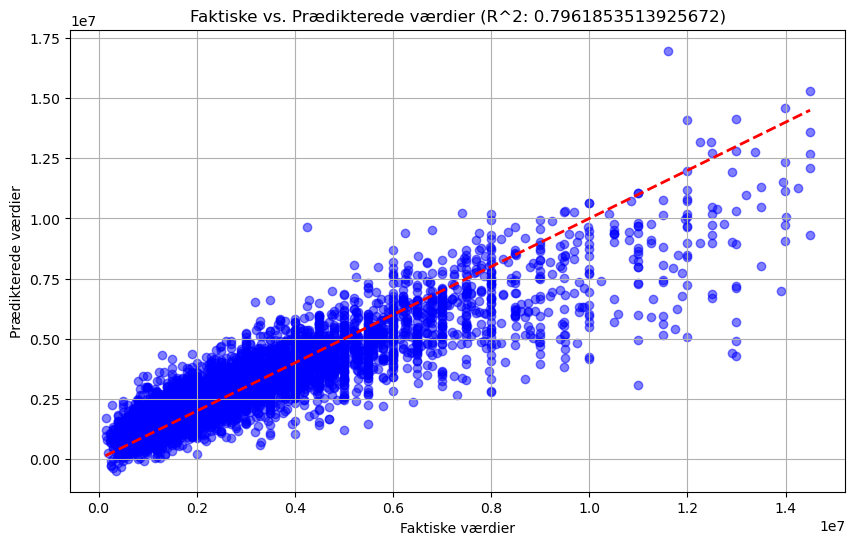

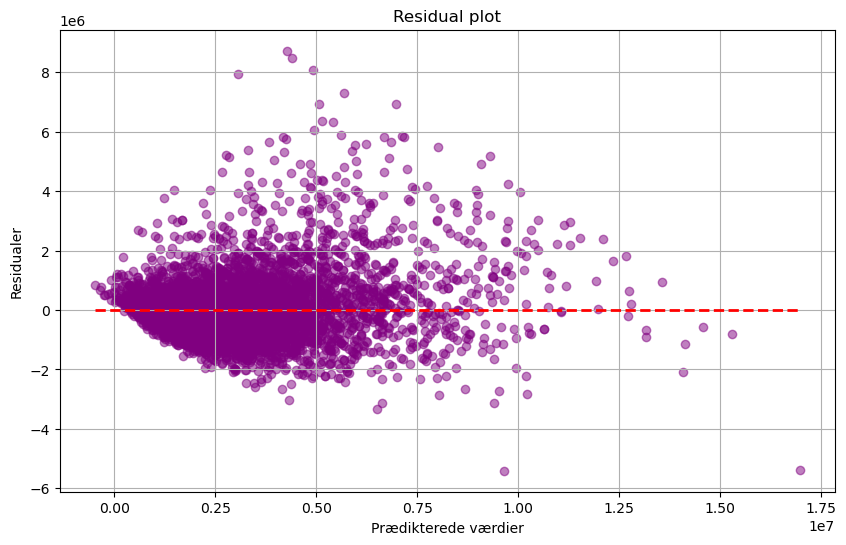

[5214912.63817321 5519578.39658095 3454123.17828736 ... 4236068.39324293
 3164442.67003702 3456811.03770701]


In [41]:
#Printing MSE, MAE, MAPE, RMSE
y_test_pred_ridge_degree_2 = pipe_ridge.predict(X_test)
print('Ridge_MSE_de2', round(mse(y_test_pred_ridge_degree_2,y_test), 2))
print('Ridge_MAE_de2', round(mean_absolute_error(y_test_pred_ridge_degree_2, y_test), 2))
print('Ridge_MAPE_de2', round(mean_absolute_percentage_error(y_test_pred_ridge_degree_2, y_test), 2))
print('Ridge_RMSE_de2', np.sqrt(mse(y_test_pred_ridge_degree_2, y_test)))
print('Ridge_R2_de2', r2_score(y_test, y_test_pred_ridge_degree_2))

# Plot af faktiske vs. prædikterede værdier
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred_ridge_degree_2, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2, linestyle='--')  # Reference linje for perfekt prædiktion
plt.xlabel('Faktiske værdier')
plt.ylabel('Prædikterede værdier')
plt.title(f'Faktiske vs. Prædikterede værdier (R^2: {r2_score(y_test, y_test_pred_ridge_degree_2)})')
plt.grid(True)
plt.show()

# Plot af residualer (fejl)
residuals = y_test - y_test_pred_ridge_degree_2

plt.figure(figsize=(10, 6))
plt.scatter(y_test_pred_ridge_degree_2, residuals, color='purple', alpha=0.5)
plt.hlines(0, y_test_pred_ridge_degree_2.min(), y_test_pred_ridge_degree_2.max(), color='red', lw=2, linestyle='--')
plt.xlabel('Prædikterede værdier')
plt.ylabel('Residualer')
plt.title('Residual plot')
plt.grid(True)
plt.show()

print(y_test_pred_ridge_degree_2)

# Ridge, polynomial-features = 1, CV=5

Optimal lambda: 0.01
Validation MSE: 1993865156109.365


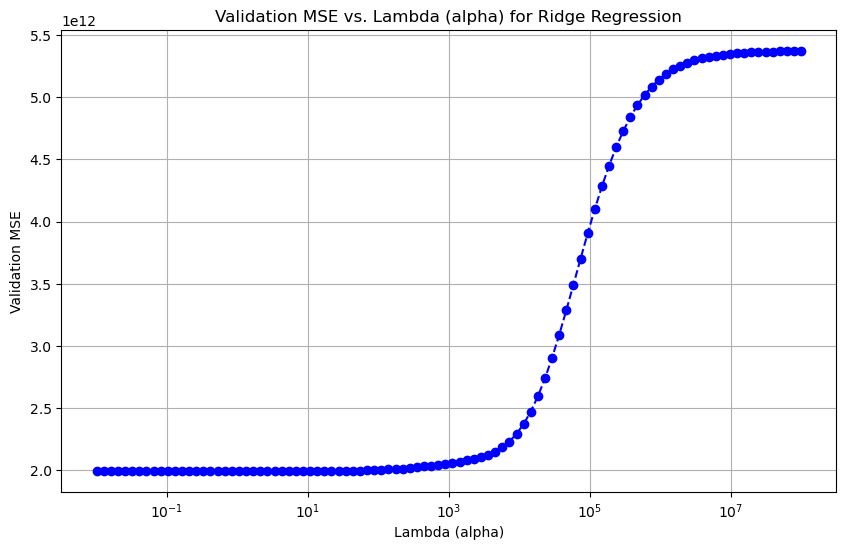

In [43]:
# PREPARATION
lambdas = np.logspace(-2, 8, 100)  # Grid of lambdas
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation

# Store performance for each alpha
perform = []

# FOR EACH LAMBDA, PERFORM 5-FOLD CROSS VALIDATION
for lambda_ in lambdas:
    fold_mse = []
    
    for train_index, val_index in kf.split(X_dev):
        X_train_fold, X_val_fold = X_dev.iloc[train_index], X_dev.iloc[val_index]
        y_train_fold, y_val_fold = y_dev.iloc[train_index], y_dev.iloc[val_index]

        # Initialize and fit the Ridge model within the pipeline
        pipe_ridge = make_pipeline(PolynomialFeatures(degree=1), 
                                   StandardScaler(),
                                   Ridge(alpha=lambda_, random_state=42))
        pipe_ridge.fit(X_train_fold, y_train_fold)
        
        # Predict on the validation fold
        y_pred_fold = pipe_ridge.predict(X_val_fold)
        
        # Calculate MSE for this fold and store it
        fold_mse.append(mse(y_val_fold, y_pred_fold))
    
    # Average MSE across all folds for the current lambda
    perform.append(np.mean(fold_mse))

# CREATE A SERIES WITH PERFORMANCE AND FIND LAMBDA WITH LOWEST MSE    
hyperparam_perform = pd.Series(perform, index=lambdas)
optimal = hyperparam_perform.nsmallest(1)    
print('Optimal lambda:', optimal.index[0])
print('Validation MSE: %.3f' % optimal.values[0])

# Visualize the validation curve
plt.figure(figsize=(10, 6))
plt.plot(lambdas, perform, marker='o', linestyle='--', color='blue')
plt.xscale('log')
plt.xlabel('Lambda (alpha)')
plt.ylabel('Validation MSE')
plt.title('Validation MSE vs. Lambda (alpha) for Ridge Regression')
plt.grid(True)
plt.show()

In [44]:
# INSERT OPTIMAL LAMBDA INTO NEW MODEL
pipe_ridge = make_pipeline(PolynomialFeatures(degree=1), 
                           StandardScaler(),
                           Ridge(alpha=optimal.index[0]))

# FIT NEW MODEL ON ALL OF THE DEVELOPMENT (non-test) DATA TO BUILD BEST POSSIBLE MODEL
pipe_ridge.fit(X_dev, y_dev) 

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=1)),
                ('standardscaler', StandardScaler()),
                ('ridge', Ridge(alpha=0.01))])

Ridge_MSE_de1_cv_5 1611440547451.5
Ridge_MAE_de1_cv_5 871354.35
Ridge_MAPE_de1_cv_5 2.61
Ridge_RMSE_de1_cv_5 1269425.282342957
Ridge_R2_de1_cv_5 0.6876160364409654


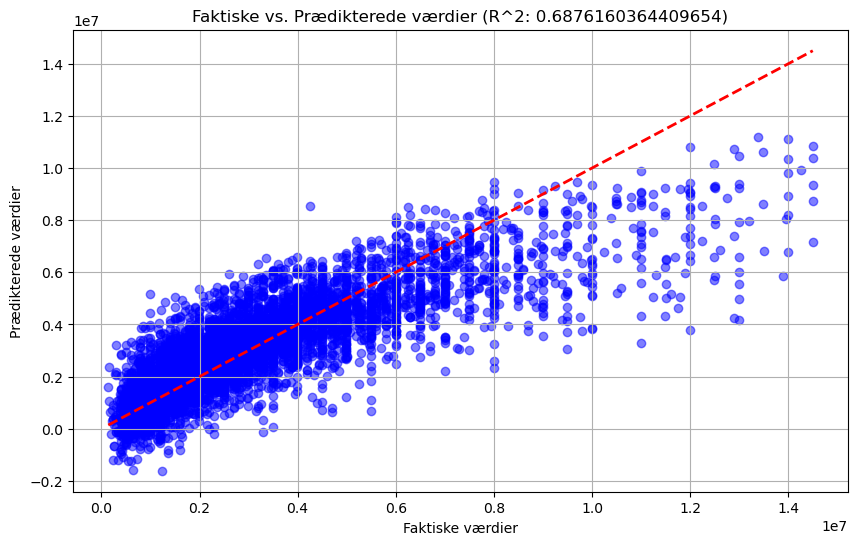

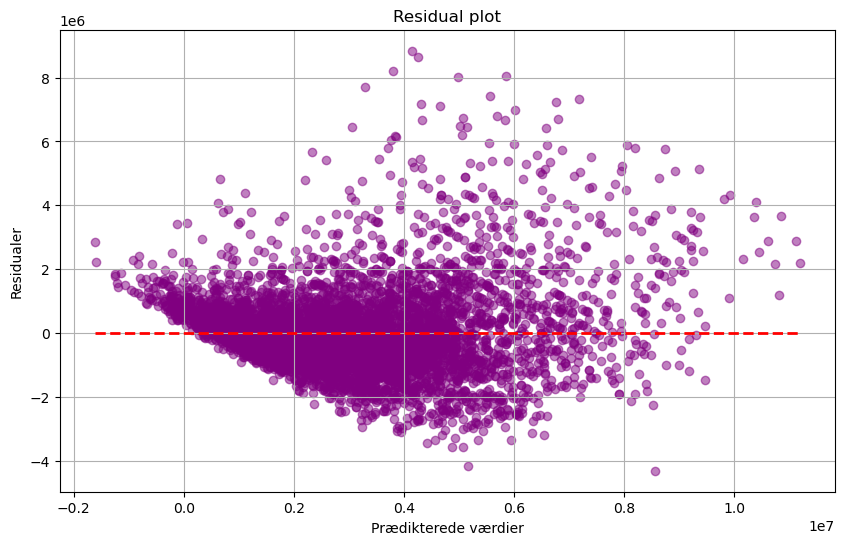

In [45]:
# Printing MSE, MAE, MAPE, RMSE
y_test_pred_ridge_degree_1_cv_5 = pipe_ridge.predict(X_test)
print('Ridge_MSE_de1_cv_5', round(mse(y_test_pred_ridge_degree_1_cv_5, y_test), 2))
print('Ridge_MAE_de1_cv_5', round(mean_absolute_error(y_test_pred_ridge_degree_1_cv_5, y_test), 2))
print('Ridge_MAPE_de1_cv_5', round(mean_absolute_percentage_error(y_test_pred_ridge_degree_1_cv_5, y_test), 2))
print('Ridge_RMSE_de1_cv_5', np.sqrt(mse(y_test_pred_ridge_degree_1_cv_5, y_test)))
print('Ridge_R2_de1_cv_5', r2_score(y_test, y_test_pred_ridge_degree_1_cv_5))


# Plot af faktiske vs. prædikterede værdier
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred_ridge_degree_1_cv_5, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2, linestyle='--')  # Reference linje for perfekt prædiktion
plt.xlabel('Faktiske værdier')
plt.ylabel('Prædikterede værdier')
plt.title(f'Faktiske vs. Prædikterede værdier (R^2: {r2_score(y_test, y_test_pred_ridge_degree_1_cv_5)})')
plt.grid(True)
plt.show()

# Plot af residualer (fejl)
residuals = y_test - y_test_pred_ridge_degree_1_cv_5

plt.figure(figsize=(10, 6))
plt.scatter(y_test_pred_ridge_degree_1_cv_5, residuals, color='purple', alpha=0.5)
plt.hlines(0, y_test_pred_ridge_degree_1_cv_5.min(), y_test_pred_ridge_degree_1_cv_5.max(), color='red', lw=2, linestyle='--')
plt.xlabel('Prædikterede værdier')
plt.ylabel('Residualer')
plt.title('Residual plot')
plt.grid(True)
plt.show()


# Ridge, polynomial-features = 2, CV=5

Optimal lambda: 1123.3240329780265
Validation MSE: 1515271198230.677


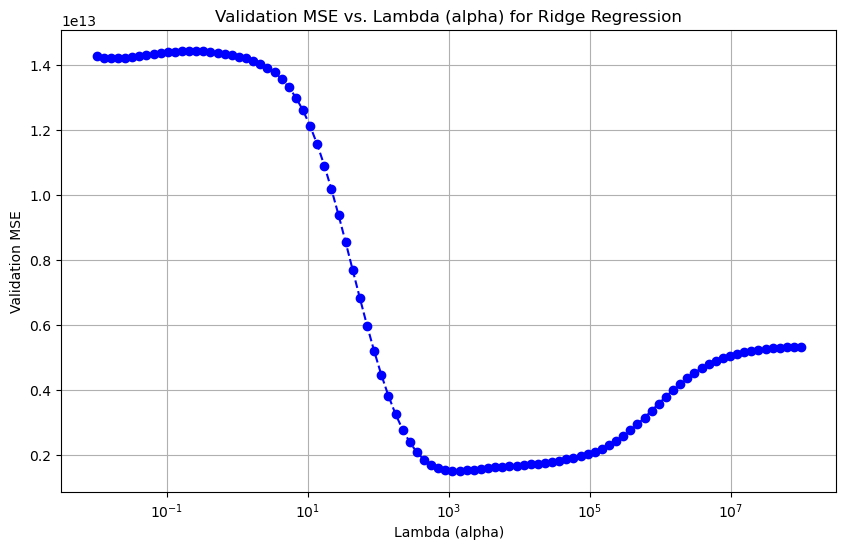

In [90]:
# PREPARATION
lambdas = np.logspace(-2, 8, 100)  # Grid of lambdas
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation

# Store performance for each alpha
perform = []

# FOR EACH LAMBDA, PERFORM 5-FOLD CROSS VALIDATION
for lambda_ in lambdas:
    fold_mse = []
    
    for train_index, val_index in kf.split(X_dev):
        X_train_fold, X_val_fold = X_dev.iloc[train_index], X_dev.iloc[val_index]
        y_train_fold, y_val_fold = y_dev.iloc[train_index], y_dev.iloc[val_index]

        # Initialize and fit the Ridge model within the pipeline
        pipe_ridge = make_pipeline(PolynomialFeatures(degree=2), 
                                   StandardScaler(),
                                   Ridge(alpha=lambda_, random_state=42))
        pipe_ridge.fit(X_train_fold, y_train_fold)
        
        # Predict on the validation fold
        y_pred_fold = pipe_ridge.predict(X_val_fold)
        
        # Calculate MSE for this fold and store it
        fold_mse.append(mse(y_val_fold, y_pred_fold))
    
    # Average MSE across all folds for the current lambda
    perform.append(np.mean(fold_mse))

# CREATE A SERIES WITH PERFORMANCE AND FIND LAMBDA WITH LOWEST MSE    
hyperparam_perform = pd.Series(perform, index=lambdas)
optimal = hyperparam_perform.nsmallest(1)    
print('Optimal lambda:', optimal.index[0])
print('Validation MSE: %.3f' % optimal.values[0])

# Visualize the validation curve
plt.figure(figsize=(10, 6))
plt.plot(lambdas, perform, marker='o', linestyle='--', color='blue')
plt.xscale('log')
plt.xlabel('Lambda (alpha)')
plt.ylabel('Validation MSE')
plt.title('Validation MSE vs. Lambda (alpha) for Ridge Regression')
plt.grid(True)
plt.show()

In [92]:
# INSERT OPTIMAL LAMBDA INTO NEW MODEL
pipe_ridge = make_pipeline(PolynomialFeatures(degree=2), 
                           StandardScaler(),
                           Ridge(alpha=optimal.index[0]))

# FIT NEW MODEL ON ALL OF THE DEVELOPMENT (non-test) DATA TO BUILD BEST POSSIBLE MODEL
pipe_ridge.fit(X_dev, y_dev) 

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('standardscaler', StandardScaler()),
                ('ridge', Ridge(alpha=1123.3240329780265))])

Ridge_MSE_de2_cv_5 881561684973.52
Ridge_MAE_de2_cv_5 621734.35
Ridge_MAPE_de2_cv_5 0.28
Ridge_RMSE_de2_cv_5 938915.1638851718
Ridge_R2_de2_cv_5 0.8291058682187604


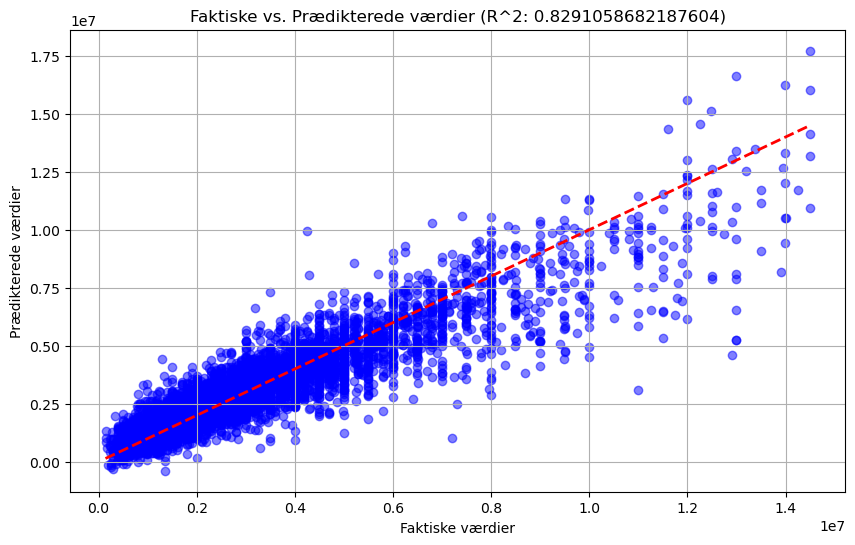

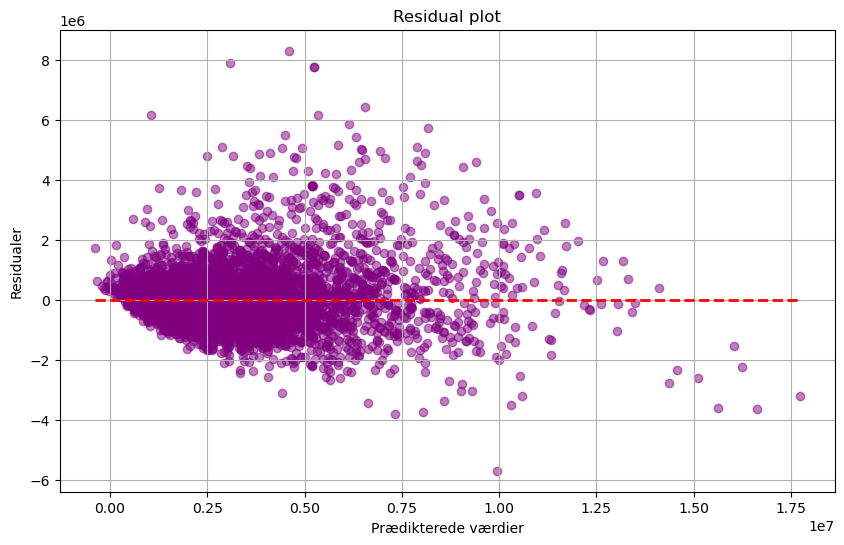

In [94]:
# Printing MSE, MAE, MAPE, RMSE
y_test_pred_ridge_degree_2_cv_5 = pipe_ridge.predict(X_test)
print('Ridge_MSE_de2_cv_5', round(mse(y_test_pred_ridge_degree_2_cv_5, y_test), 2))
print('Ridge_MAE_de2_cv_5', round(mean_absolute_error(y_test_pred_ridge_degree_2_cv_5, y_test), 2))
print('Ridge_MAPE_de2_cv_5', round(mean_absolute_percentage_error(y_test_pred_ridge_degree_2_cv_5, y_test), 2))
print('Ridge_RMSE_de2_cv_5', np.sqrt(mse(y_test_pred_ridge_degree_2_cv_5, y_test)))
print('Ridge_R2_de2_cv_5', r2_score(y_test, y_test_pred_ridge_degree_2_cv_5))


# Plot af faktiske vs. prædikterede værdier
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred_ridge_degree_2_cv_5, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2, linestyle='--')  # Reference linje for perfekt prædiktion
plt.xlabel('Faktiske værdier')
plt.ylabel('Prædikterede værdier')
plt.title(f'Faktiske vs. Prædikterede værdier (R^2: {r2_score(y_test, y_test_pred_ridge_degree_2_cv_5)})')
plt.grid(True)
plt.show()

# Plot af residualer (fejl)
residuals = y_test - y_test_pred_ridge_degree_2_cv_5

plt.figure(figsize=(10, 6))
plt.scatter(y_test_pred_ridge_degree_2_cv_5, residuals, color='purple', alpha=0.5)
plt.hlines(0, y_test_pred_ridge_degree_2_cv_5.min(), y_test_pred_ridge_degree_2_cv_5.max(), color='red', lw=2, linestyle='--')
plt.xlabel('Prædikterede værdier')
plt.ylabel('Residualer')
plt.title('Residual plot')
plt.grid(True)
plt.show()


In [96]:
from sklearn.model_selection import validation_curve
lambdas = np.logspace(0, 7, 66) # Grid of lambdas
# FIT AND EVALUATE FOR DIFFERENT LAMBDAS
train_scores, test_scores = \
    validation_curve(estimator=pipe_ridge,
                     X=X_dev,
                     y=y_dev,
                     param_name='ridge__alpha', #built-in name of hyperparameter
                     param_range=lambdas, #values to consider
                     scoring='neg_mean_squared_error',
                     cv=5
                     )

# OBTAIN MSE FOR DIFFERENT LAMBDAS AND PRINT BEST
mse_score = pd.DataFrame({'Train':-train_scores.mean(axis=1),
                          'Validation':-test_scores.mean(axis=1),
                          'lambda':lambdas})\
              .set_index('lambda')   
print(mse_score.Validation.nsmallest(1))

lambda
1327.629589    1.394195e+12
Name: Validation, dtype: float64


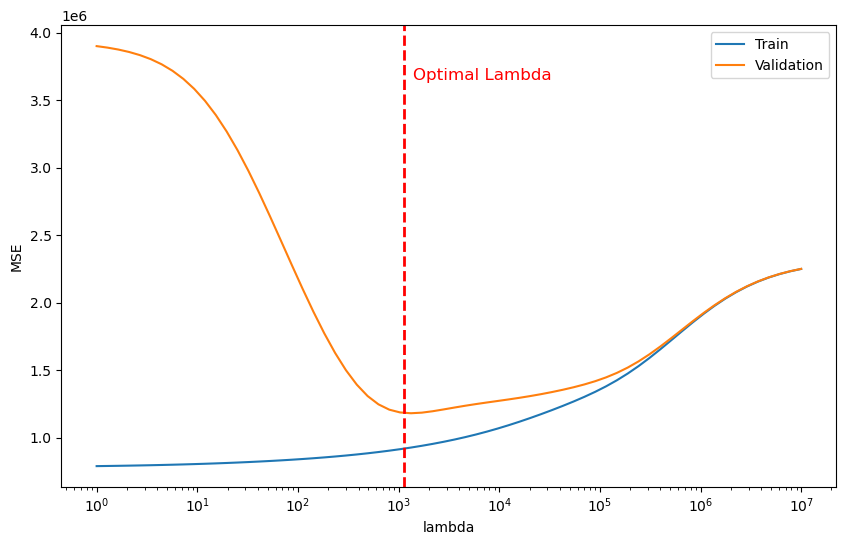

In [114]:
np.sqrt(mse_score).plot(logx=True, figsize=(10,6));
plt.axvline(x=1123, color='red', linestyle='--', linewidth=2)
plt.text(1400, plt.ylim()[1]*0.9, 'Optimal Lambda', color='red', fontsize=12)
plt.ylabel('MSE')
plt.savefig('../outputdata/validation_curve.png', dpi=300, bbox_inches='tight')
plt.show()

# RandomForestRegressor, degree=1, CV=0

In [51]:
from sklearn.ensemble import RandomForestRegressor

pipe_Randomforrest = make_pipeline(PolynomialFeatures(degree=1), 
                           StandardScaler(),
                           RandomForestRegressor(random_state=42))


pipe_Randomforrest.fit(X_dev, y_dev)



Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=1)),
                ('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

RandomForrest_MSE_de1 810161244441.54
RandomForrest_MAE_de1 568997.33
RandomForrest_MAPE_de1 0.21
RandomForrest_RMSE_de1 900089.5757876236
RandomForrest_R2_de1 0.842947118923612


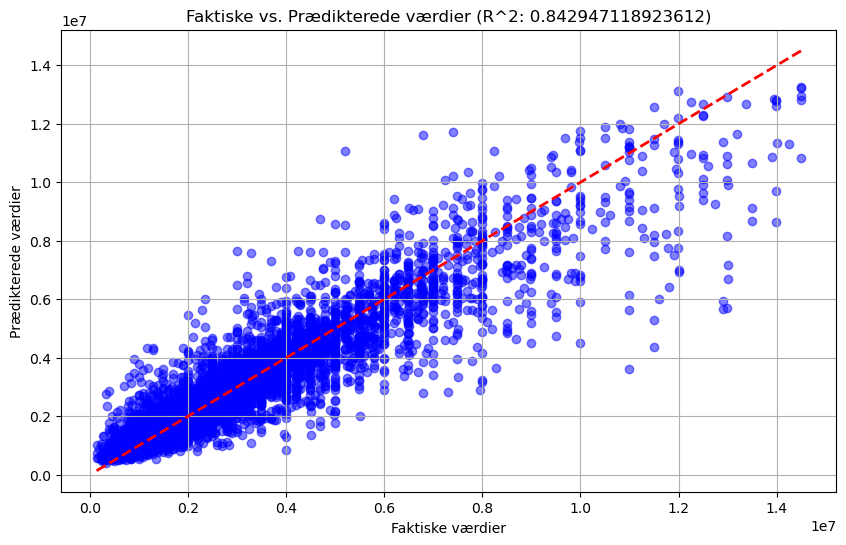

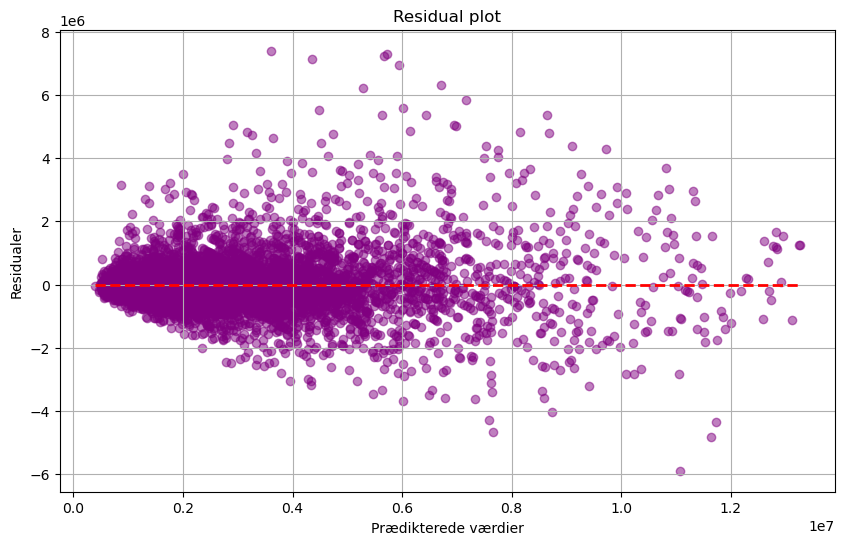

In [52]:
y_test_pred_randomforrest_degree_1 = pipe_Randomforrest.predict(X_test)
print('RandomForrest_MSE_de1', round(mse(y_test_pred_randomforrest_degree_1,y_test), 2))
print('RandomForrest_MAE_de1', round(mean_absolute_error(y_test_pred_randomforrest_degree_1, y_test), 2))
print('RandomForrest_MAPE_de1', round(mean_absolute_percentage_error(y_test_pred_randomforrest_degree_1, y_test), 2))
print('RandomForrest_RMSE_de1', np.sqrt(mse(y_test_pred_randomforrest_degree_1, y_test)))
print('RandomForrest_R2_de1', r2_score(y_test, y_test_pred_randomforrest_degree_1))

# Plot af faktiske vs. prædikterede værdier
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred_randomforrest_degree_1, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2, linestyle='--')  # Reference linje for perfekt prædiktion
plt.xlabel('Faktiske værdier')
plt.ylabel('Prædikterede værdier')
plt.title(f'Faktiske vs. Prædikterede værdier (R^2: {r2_score(y_test, y_test_pred_randomforrest_degree_1)})')
plt.grid(True)
plt.show()

# Plot af residualer (fejl)
residuals = y_test - y_test_pred_randomforrest_degree_1

plt.figure(figsize=(10, 6))
plt.scatter(y_test_pred_randomforrest_degree_1, residuals, color='purple', alpha=0.5)
plt.hlines(0, y_test_pred_randomforrest_degree_1.min(), y_test_pred_randomforrest_degree_1.max(), color='red', lw=2, linestyle='--')
plt.xlabel('Prædikterede værdier')
plt.ylabel('Residualer')
plt.title('Residual plot')
plt.grid(True)
plt.show()



# Randomforrest tuning

In [56]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Step 6: Define the pipeline with StandardScaler and RandomForestRegressor
pipeline = make_pipeline(
    StandardScaler(),  # Step for standardization
    RandomForestRegressor(random_state=42)  # Random Forest model
)

# Step 7: Define the hyperparameter grid for RandomizedSearchCV
param_distributions = {
    'randomforestregressor__n_estimators': [50, 100, 500],
    'randomforestregressor__max_features': ['sqrt', 'log2', None],
    'randomforestregressor__max_depth': [10, 30, None],
    'randomforestregressor__min_samples_split': [2, 5],
    'randomforestregressor__min_samples_leaf': [1, 2],
    #'randomforestregressor__bootstrap': [True, False]
}

# Step 8: Set up RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=pipeline, param_distributions=param_distributions,
                                   n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1,
                                   scoring='neg_mean_squared_error')

grid_search = GridSearchCV(estimator=pipeline, param_grid=param_distributions,
                                     cv=3, verbose=2, n_jobs=-1,
                                   scoring='neg_mean_squared_error')



# Step 9: Fit the model to the training data (X_train, y_train)
random_search.fit(X_dev, y_dev) 
best_params = random_search.best_params_
best_pipeline = random_search.best_estimator_

# Step 10: fit best model on dev set
best_pipeline.fit(X_dev, y_dev)  # Retrain on the full development set (X_dev, y_dev)
y_test_pred = best_pipeline.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
print(f"Test MSE: {test_mse}")

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Test MSE: 809782537303.4352


In [57]:
y_test_pred_randomforrest_tun = best_pipeline.predict(X_test)
print('RandomForrest_MSE_tun', round(mse(y_test_pred_randomforrest_tun,y_test), 2))
print('RandomForrest_MAE_tun', round(mean_absolute_error(y_test_pred_randomforrest_tun, y_test), 2))
print('RandomForrest_MAPE_tun', round(mean_absolute_percentage_error(y_test_pred_randomforrest_tun, y_test), 2))
print('RandomForrest_RMSE_tun', np.sqrt(mse(y_test_pred_randomforrest_tun, y_test)))
print('RandomForrest_R2_tun', r2_score(y_test, y_test_pred_randomforrest_tun))
best_params


RandomForrest_MSE_tun 809782537303.44
RandomForrest_MAE_tun 559411.99
RandomForrest_MAPE_tun 0.2
RandomForrest_RMSE_tun 899879.1792809939
RandomForrest_R2_tun 0.8430205327625635


{'randomforestregressor__n_estimators': 500,
 'randomforestregressor__min_samples_split': 2,
 'randomforestregressor__min_samples_leaf': 1,
 'randomforestregressor__max_features': 'sqrt',
 'randomforestregressor__max_depth': None}

In [58]:
# Step 11: Retrieve the feature importances from the best model
# Assuming X_dev is a DataFrame with feature names
importances = best_pipeline.named_steps['randomforestregressor'].feature_importances_

# If X_dev is a pandas DataFrame, you can align the feature importances with the feature names:
if hasattr(X_dev, 'columns'):
    feature_importance_df = pd.DataFrame({
        'Feature': X_dev.columns,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    #print(feature_importance_df)
else:
    # If X_dev is not a DataFrame, just print the importances
    print(importances)


# Plot the feature importances
"""
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # To display the most important feature on top
plt.show()
"""
feature_importance_df


,Feature,Importance
7,Ejerudgift,0.258130
5,m2,0.088557
19,Gennemsnitlig_pendligafstand,0.065371
6,Grund,0.053504
15,"m2 parker, sportsanlæg og rekreative omr pr indbygger",0.050561
14,Familiernes gennemsnitlige indkomst indkomst,0.041331
2,Kommuneskat,0.040164
9,Build,0.039600
10,Toilets,0.034166
8,Rooms,0.034165


0.7948798001873244


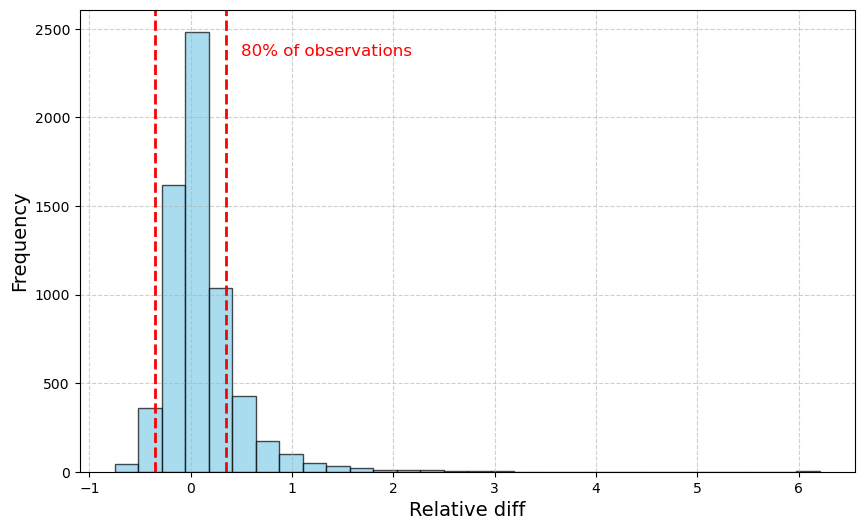

In [59]:
diff = (y_test_pred_randomforrest_tun - y_test)/y_test
# Determine the observations within the 15% threshold
within_15_percent = np.abs(diff) <= 0.35

# Count the observations
count_within_15_percent = np.sum(within_15_percent)

#
andel = count_within_15_percent/len(diff)
print(andel)


##Histogram
# Create the histogram
plt.figure(figsize=(10, 6))  # Set the figure size
plt.hist(diff, bins=30, color='skyblue', edgecolor='black', alpha=0.7)  # Customize the histogram

# Add titles and labels
plt.xlabel('Relative diff', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Customize the grid
plt.grid(True, linestyle='--', alpha=0.6)

# Add a vertical line at the mean
#plt.axvline(diff.mean(), color='red', linestyle='dashed', linewidth=2)
plt.axvline(0.35, color='red', linestyle='dashed', linewidth=2)
plt.text(0.5, plt.ylim()[1]*0.9, '80% of observations', color='red', fontsize=12)
plt.axvline(-0.35, color='red', linestyle='dashed', linewidth=2)

#plt.text(diff.mean(), plt.ylim()[1]*0.9, f'Mean: {diff.mean():.2f}', color='red', fontsize=12)
plt.savefig('../outputdata/randomForrest_density.png', dpi=300, bbox_inches='tight')
# Show the plot
plt.show()

# Learning curve

In [66]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    estimator=best_pipeline,
    X=X, #OBS HELE DATASET
    y=y, #OBS HELE DATASET
    cv=5,
    scoring="neg_mean_squared_error",
    train_sizes = [500, 1000, 2500, 5000, 7500, 9430, 12500, 15372] #RET SLUT PUNKT
)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# Calculate mean and standard deviation for training and validation scores
train_mean = -train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
test_mean = -test_scores.mean(axis=1)
test_std = test_scores.std(axis=1)




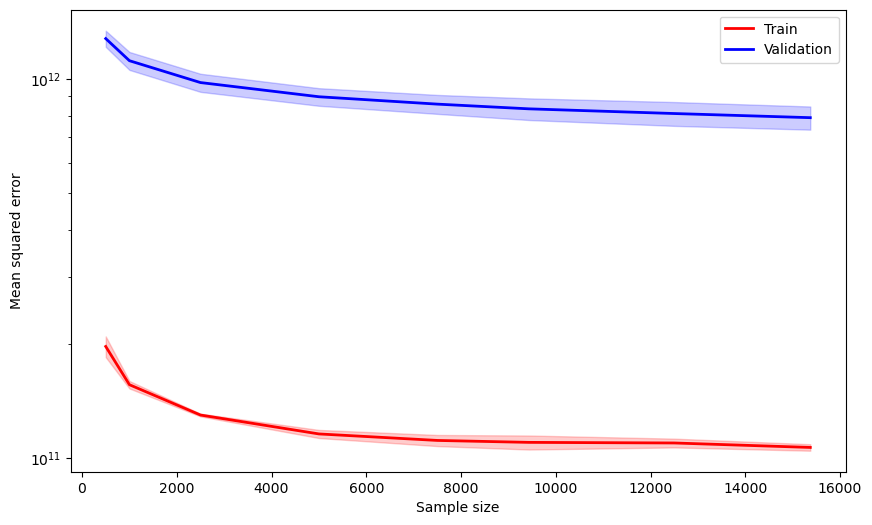

In [68]:
plt.figure(figsize=(10, 6))

# Plot learning curve with shaded error bands
plt.plot(train_sizes, train_mean, 'r-', label='Train', lw=2)
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='r', alpha=0.2)
plt.plot(train_sizes, test_mean, 'b-', label='Validation', lw=2)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='b', alpha=0.2)

#plt.title("Learning Curve")
plt.xlabel("Sample size")
plt.ylabel("Mean squared error")
plt.yscale('log')  # Logarithmic scale for y-axis
plt.legend(loc="best")
plt.savefig('../outputdata/learning_curve.png', dpi=300, bbox_inches='tight')

plt.show()

In [70]:
print(test_mean)

[1.27694832e+12 1.11626348e+12 9.77381198e+11 8.96608106e+11
 8.57277811e+11 8.33112768e+11 8.09662683e+11 7.89517952e+11]


# Conclusion

In [84]:
print('LinReg_MSE_de1', round(mse(y_predict_lr_degree_1,y_test), 2))
print('LinReg_MSE_de2', round(mse(y_predict_lr_degree_2,y_test), 2))
print('Lasso_MSE_de1', round(mse(y_test_pred_lasso_degree_1,y_test), 2))
print('Lasso_MSE_de2', round(mse(y_test_pred_lasso_degree_2,y_test), 2))
print('Lasso_MSE_de1_cv_5', round(mse(y_test_pred_lasso_degree_1_cv_5, y_test), 2))
#print('Lasso_MSE_de2_cv_5', round(mse(y_test_pred_lasso_degree_2_cv_5, y_test), 2))
print('Ridge_MSE_de1', round(mse(y_test_pred_ridge_degree_1,y_test), 2))
print('Ridge_MSE_de2', round(mse(y_test_pred_ridge_degree_2,y_test), 2))
print('Ridge_MSE_de1_cv_5', round(mse(y_test_pred_ridge_degree_1_cv_5, y_test), 2))
print('Ridge_MSE_de2_cv_5', round(mse(y_test_pred_ridge_degree_2_cv_5, y_test), 2))
print('RandomForrest_MSE_de1', round(mse(y_test_pred_randomforrest_degree_1,y_test), 2))
#print('RandomForrest_MSE_de1', round(mse(y_test_pred_randomforrest_degree_2,y_test), 2))
print("")

print('LinReg_RMSE_de1', np.sqrt(mse(y_predict_lr_degree_1,y_test)))
print('LinReg_RMSE_de2', np.sqrt(mse(y_predict_lr_degree_2,y_test)))
print('Lasso_RMSE_de1', np.sqrt(mse(y_test_pred_lasso_degree_1,y_test)))
print('Lasso_RMSE_de2', np.sqrt(mse(y_test_pred_lasso_degree_2,y_test)))
print('Lasso_RMSE_de1_cv_5', np.sqrt(mse(y_test_pred_lasso_degree_1_cv_5, y_test)))
#print('Lasso_RMSE_de2_cv_5', np.sqrt(mse(y_test_pred_lasso_degree_2_cv_5, y_test)))
print('Ridge_RMSE_de1', np.sqrt(mse(y_test_pred_ridge_degree_1,y_test)))
print('Ridge_RMSE_de2', np.sqrt(mse(y_test_pred_ridge_degree_2,y_test)))
print('Ridge_RMSE_de1_cv_5', np.sqrt(mse(y_test_pred_ridge_degree_1_cv_5, y_test)))
print('Ridge_RMSE_de2_cv_5', np.sqrt(mse(y_test_pred_ridge_degree_2_cv_5, y_test)))
print('RandomForrest_RMSE_de1', np.sqrt(mse(y_test_pred_randomforrest_degree_1,y_test)))


table = {
    'OLS 1-deg': {
        'MSE': round(mse(y_predict_lr_degree_1,y_test), 2),
        'RMSE': np.sqrt(mse(y_predict_lr_degree_1,y_test)),
        'MAE': round(mean_absolute_error(y_predict_lr_degree_1,y_test), 2),
        'MAPE': round(mean_absolute_percentage_error(y_predict_lr_degree_1,y_test), 2),
        'R2': r2_score(y_test, y_predict_lr_degree_1)
    },
    'OLS 2-deg': {
        'MSE': round(mse(y_predict_lr_degree_2,y_test), 2),
        'RMSE': np.sqrt(mse(y_predict_lr_degree_2,y_test)),
        'MAE': round(mean_absolute_error(y_predict_lr_degree_2,y_test), 2),
        'MAPE': round(mean_absolute_percentage_error(y_predict_lr_degree_2,y_test), 2),
        'R2': r2_score(y_test, y_predict_lr_degree_2)
    },
    'LASSO 1-deg': {
        'MSE': round(mse(y_test_pred_lasso_degree_1,y_test), 2),
        'RMSE': np.sqrt(mse(y_test_pred_lasso_degree_1,y_test)),
        'MAE': round(mean_absolute_error(y_test_pred_lasso_degree_1,y_test), 2),
        'MAPE': round(mean_absolute_percentage_error(y_test_pred_lasso_degree_1,y_test), 2),
        'R2': r2_score(y_test, y_test_pred_lasso_degree_1)
    },
    'LASSO 2-deg': {
        'MSE': round(mse(y_test_pred_lasso_degree_2,y_test), 2),
        'RMSE': np.sqrt(mse(y_test_pred_lasso_degree_2,y_test)),
        'MAE': round(mean_absolute_error(y_test_pred_lasso_degree_2,y_test), 2),
        'MAPE': round(mean_absolute_percentage_error(y_test_pred_lasso_degree_2,y_test), 2),
        'R2': r2_score(y_test, y_test_pred_lasso_degree_2)
    },
     'LASSO 1-deg, CV-5': {
        'MSE': round(mse(y_test_pred_lasso_degree_1_cv_5,y_test), 2),
        'RMSE': np.sqrt(mse(y_test_pred_lasso_degree_1_cv_5,y_test)),
        'MAE': round(mean_absolute_error(y_test_pred_lasso_degree_1_cv_5,y_test), 2),
        'MAPE': round(mean_absolute_percentage_error(y_test_pred_lasso_degree_1_cv_5,y_test), 2),
        'R2': r2_score(y_test, y_test_pred_lasso_degree_1_cv_5)
     },
    'RIDGE 1-deg': {
        'MSE': round(mse(y_test_pred_ridge_degree_1,y_test), 2),
        'RMSE': np.sqrt(mse(y_test_pred_ridge_degree_1,y_test)),
        'MAE': round(mean_absolute_error(y_test_pred_ridge_degree_1,y_test), 2),
        'MAPE': round(mean_absolute_percentage_error(y_test_pred_ridge_degree_1,y_test), 2),
        'R2': r2_score(y_test, y_test_pred_ridge_degree_1)
    },
    'RIDGE 2-deg': {
        'MSE': round(mse(y_test_pred_ridge_degree_2,y_test), 2),
        'RMSE': np.sqrt(mse(y_test_pred_ridge_degree_2,y_test)),
        'MAE': round(mean_absolute_error(y_test_pred_ridge_degree_2,y_test), 2),
        'MAPE': round(mean_absolute_percentage_error(y_test_pred_ridge_degree_2,y_test), 2),
        'R2': r2_score(y_test, y_test_pred_ridge_degree_2)
    },
    'RIDGE 1-deg, CV-5': {
        'MSE': round(mse(y_test_pred_ridge_degree_1_cv_5,y_test), 2),
        'RMSE': np.sqrt(mse(y_test_pred_ridge_degree_1_cv_5,y_test)),
        'MAE': round(mean_absolute_error(y_test_pred_ridge_degree_1_cv_5,y_test), 2),
        'MAPE': round(mean_absolute_percentage_error(y_test_pred_ridge_degree_1_cv_5,y_test), 2),
        'R2': r2_score(y_test, y_test_pred_ridge_degree_1_cv_5)
    },
    'RIDGE 2-deg, CV-5': {
        'MSE': round(mse(y_test_pred_ridge_degree_2_cv_5,y_test), 2),
        'RMSE': np.sqrt(mse(y_test_pred_ridge_degree_2_cv_5,y_test)),
        'MAE': round(mean_absolute_error(y_test_pred_ridge_degree_2_cv_5,y_test), 2),
        'MAPE': round(mean_absolute_percentage_error(y_test_pred_ridge_degree_2_cv_5,y_test), 2),
        'R2': r2_score(y_test, y_test_pred_ridge_degree_2_cv_5)
    },
    'RANDOMFORREST': {
        'MSE': round(mse(y_test_pred_randomforrest_degree_1,y_test), 2),
        'RMSE': np.sqrt(mse(y_test_pred_randomforrest_degree_1,y_test)),
        'MAE': round(mean_absolute_error(y_test_pred_randomforrest_degree_1,y_test), 2),
        'MAPE': round(mean_absolute_percentage_error(y_test_pred_randomforrest_degree_1,y_test), 2),
        'R2': r2_score(y_test, y_test_pred_randomforrest_degree_1)
    },
    'RANDOMFORREST tunned': {
        'MSE': round(mse(y_test_pred_randomforrest_tun,y_test), 2),
        'RMSE': np.sqrt(mse(y_test_pred_randomforrest_tun,y_test)),
        'MAE': round(mean_absolute_error(y_test_pred_randomforrest_tun,y_test), 2),
        'MAPE': round(mean_absolute_percentage_error(y_test_pred_randomforrest_tun,y_test), 2),
        'R2': r2_score(y_test, y_test_pred_randomforrest_tun)
    }
}

conclusion_df = pd.DataFrame(table).T

# Function to format numbers based on their magnitude
def format_number(x):
    if abs(x) >= 1e7 or abs(x) < 1e-2:  # More than 7 digits or very small numbers
        return "%.2e" % x
    else:
        return "%.2f" % x

# Apply the custom formatting to all columns in the DataFrame
conclusion_df = conclusion_df.applymap(format_number)

# Now convert the DataFrame to LaTeX
latex_code = conclusion_df.to_latex(index=True, escape=False)



LinReg_MSE_de1 1611440904707.61
LinReg_MSE_de2 3.257703830559236e+30
Lasso_MSE_de1 1609887181281.63
Lasso_MSE_de2 999661342526.52
Lasso_MSE_de1_cv_5 1611440891992.88
Ridge_MSE_de1 1610838672846.31
Ridge_MSE_de2 1051383000550.63
Ridge_MSE_de1_cv_5 1611440547451.5
Ridge_MSE_de2_cv_5 881561684973.52
RandomForrest_MSE_de1 810161244441.54

LinReg_RMSE_de1 1269425.4230586411
LinReg_RMSE_de2 1804911031203265.8
Lasso_RMSE_de1 1268813.2964631293
Lasso_RMSE_de2 999830.6569247196
Lasso_RMSE_de1_cv_5 1269425.4180505748
Ridge_RMSE_de1 1269188.194416537
Ridge_RMSE_de2 1025369.6896976368
Ridge_RMSE_de1_cv_5 1269425.282342957
Ridge_RMSE_de2_cv_5 938915.1638851718
RandomForrest_RMSE_de1 900089.5757876236


C:\Users\matli\AppData\Local\Temp\ipykernel_7544\300796529.py:118: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  conclusion_df = conclusion_df.applymap(format_number)


In [86]:

print(latex_code)
conclusion_df

\begin{tabular}{llllll}
\toprule
 & MSE & RMSE & MAE & MAPE & R2 \\
\midrule
OLS 1-deg & 1.61e+12 & 1269425.42 & 871354.74 & 2.65 & 0.69 \\
OLS 2-deg & 3.26e+30 & 1.80e+15 & 7.59e+13 & 0.33 & -6.32e+17 \\
LASSO 1-deg & 1.61e+12 & 1268813.30 & 869326.22 & 0.73 & 0.69 \\
LASSO 2-deg & 1.00e+12 & 999830.66 & 673547.36 & 0.27 & 0.81 \\
LASSO 1-deg, CV-5 & 1.61e+12 & 1269425.42 & 871354.73 & 2.65 & 0.69 \\
RIDGE 1-deg & 1.61e+12 & 1269188.19 & 870426.78 & 1.04 & 0.69 \\
RIDGE 2-deg & 1.05e+12 & 1025369.69 & 681528.00 & 0.31 & 0.80 \\
RIDGE 1-deg, CV-5 & 1.61e+12 & 1269425.28 & 871354.35 & 2.61 & 0.69 \\
RIDGE 2-deg, CV-5 & 8.82e+11 & 938915.16 & 621734.35 & 0.28 & 0.83 \\
RANDOMFORREST & 8.10e+11 & 900089.58 & 568997.33 & 0.21 & 0.84 \\
RANDOMFORREST tunned & 8.10e+11 & 899879.18 & 559411.99 & 0.20 & 0.84 \\
\bottomrule
\end{tabular}



,MSE,RMSE,MAE,MAPE,R2
OLS 1-deg,1.61e+12,1269425.42,871354.74,2.65,0.69
OLS 2-deg,3.26e+30,1.80e+15,7.59e+13,0.33,-6.32e+17
LASSO 1-deg,1.61e+12,1268813.30,869326.22,0.73,0.69
LASSO 2-deg,1.00e+12,999830.66,673547.36,0.27,0.81
"LASSO 1-deg, CV-5",1.61e+12,1269425.42,871354.73,2.65,0.69
RIDGE 1-deg,1.61e+12,1269188.19,870426.78,1.04,0.69
RIDGE 2-deg,1.05e+12,1025369.69,681528.00,0.31,0.80
"RIDGE 1-deg, CV-5",1.61e+12,1269425.28,871354.35,2.61,0.69
"RIDGE 2-deg, CV-5",8.82e+11,938915.16,621734.35,0.28,0.83
RANDOMFORREST,8.10e+11,900089.58,568997.33,0.21,0.84


# Printing list of features

In [ ]:
# Example list of column names (replace this with your actual DataFrame column names)
features = df_final.columns.tolist()

# Organize the features into two columns
def organize_into_columns(features):
    mid = len(features) // 2 + len(features) % 2  # Split list roughly in half
    col1 = features[:mid]
    col2 = features[mid:]
    if len(col1) > len(col2):
        col2.append("")  # Ensure both columns have the same length
    return pd.DataFrame({'Column 1': col1, 'Column 2': col2})

df_features = organize_into_columns(features)
#Convert the DataFrame to LaTeX code with a longtable environment
latex_code = df_features.to_latex(index=False, header=True, longtable=False)


print(len(features))
print(features)
print(latex_code)